<p style="text-align:center;">
<img src="https://qualitasconsortium.uk/wp-content/uploads/2023/03/nhs-england-logo.png"
     alt="NHSBanner"
     style="float: center; margin-right: 10px;"
     width="680" height="260" />
</p>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import tools for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # For splitting data and tuning models
from sklearn.ensemble import RandomForestClassifier  # For building a Random Forest model
from sklearn.metrics import classification_report, confusion_matrix  # For checking model performance
from sklearn import tree # For plotting tree
from sklearn import metrics

#### Some useful functions for model evaluation

In [2]:
def apr(y_pred, y_real):
    """ Calculates accuracy, precision, recall
        Requires predicted value first, and then the real value
    """
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

def produce_confusion(positive_label:str, negative_label:str, cut_off, df, y_pred_name, y_real_name):
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(df[y_real_name], df['pred_binary']))

    return accuracy_score(df[y_real_name], df['pred_binary'])

## 1. Import Data

In [3]:
df = pd.read_csv('mecare_anonymised_full.csv')

# Show all columns in a DataFrame
pd.set_option('display.max_columns', None)

In [4]:
# Quick check of the dataframe
df.head()

Q141  \
0  I have read and understood this information ab...   
1                                                Yes   
2                                                Yes   
3                                                Yes   
4                                                Yes   

                                                Q143  \
0  I agree to take part in MeCareNWL and the long...   
1                                                Yes   
2                                                Yes   
3                                                Yes   
4                                                Yes   

                                                Q145  \
0  Would you like to hear about other studies in ...   
1                                                 No   
2                                                Yes   
3                                                Yes   
4                                                Yes   

                                                Q159               Q165  \
0  Does the organisation you work for provide acu...  Your age (years):   
1                                              Acute                 37   
2                                              Acute                 51   
3                                              Acute                 51   
4                                              Acute                 65   

      Q167                               Q169  \
0  Gender:  What is your relationship status?   
1     Male    Co-habiting / In a relationship   
2   Female                             Single   
3   Female        Married / Civil partnership   
4   Female        Married / Civil partnership   

                                                Q171  \
0  What is your ethnic group? \nPlease choose one...   
1  White English/Welsh/Scottish/Northern Irish/Br...   
2  White English/Welsh/Scottish/Northern Irish/Br...   
3  White English/Welsh/Scottish/Northern Irish/Br...   
4  White English/Welsh/Scottish/Northern Irish/Br...   

                             Q173                                   Q175  \
0  What is your country of birth?  Please specify your country of birth:   
1                  United Kingdom                                    NaN   
2                  United Kingdom                                    NaN   
3                  United Kingdom                                    NaN   
4                  United Kingdom                                    NaN   

                                                Q177  \
0  How long have you been living in the United Ki...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                            Q179                                         Q181  \
0  What is your role? (required)  If both, what is your main role? (required)   
1                       Clinical                                          NaN   
2                       Clinical                                          NaN   
3                       Clinical                                          NaN   
4                           Both                                 Non-clinical   

                 Q183                  Q185  \
0  Are you a student?  Are you a volunteer?   
1                  No                    No   
2                  No                    No   
3                  No                    No   
4                  No                    No   

                                       Q191  \
0  What is your Agenda for Change pay rate?   
1                                    Band 7   
2                                    Band 7   
3                            Not applicable   
4                                    Band 8   

                                              Q197  \
0  Which of the following describes your subgroup?   

In [5]:
df.shape

(1066, 194)

The content of this dataset comes from a survey. The question number is the field name, and the first row of the dataset is the question being asked. This will need to be changed during section _2. Data Preparation_.

For now, I want to see what all of the questions are (right now they are being truncated).

This is important to understand the data. This is also important for data cleaning/feature engineering, as there are 194 fields in this dataset, a lot of which will not be necessary for our analysis. Therefore, we need to know which columns to drop (there will be a lot of them!)

In [6]:
# This code will allow us to see the full contents of each cell in the dataset without truncation
pd.set_option('display.max_colwidth', None)

In [7]:
df.head(1)

Q141  \
0  I have read and understood this information about the MeCareNWL study.   

                                                                                                                                                                                                   Q143  \
0  I agree to take part in MeCareNWL and the long-term, storage of my survey data in line with GDPR.\nI understand that although this involves follow up surveys, I can choose to withdraw at any time.   

                                                        Q145  \
0  Would you like to hear about other studies in the future?   

                                                                  Q159  \
0  Does the organisation you work for provide acute or non-acute care?   

                Q165     Q167                               Q169  \
0  Your age (years):  Gender:  What is your relationship status?   

                                                                                                         Q171  \
0  What is your ethnic group? \nPlease choose one option that best describes your ethnic group or background.   

                             Q173                                   Q175  \
0  What is your country of birth?  Please specify your country of birth:   

                                                   Q177  \
0  How long have you been living in the United Kingdom?   

                            Q179                                         Q181  \
0  What is your role? (required)  If both, what is your main role? (required)   

                 Q183                  Q185  \
0  Are you a student?  Are you a volunteer?   

                                       Q191  \
0  What is your Agenda for Change pay rate?   

                                              Q197  \
0  Which of the following describes your subgroup?   

                                Q201  \
0  Are you a permanent staff member?   

                                                            Q203  \
0  Do you line manage or directly supervise other staff members?   

                                                     Q205  \
0  Length of time since gaining professional registration   

                                                                 Q207  \
0  Were you fast-tracked to employment due to COVID-19 (coronavirus)?   

                                                                                                                                                 Q215  \
0  Do you feel the organisation where you are working (paid or voluntary) is supporting you in the transition from student to qualified professional?   

                                                                          Q217  \
0  Did you return from retirement to employment due to COVID-19 (coronavirus)?   

                                                Q221  \
0  Length of time at current employing organisation:   

                                                                                Q229  \
0  Prior to the COVID-19 (coronavirus) pandemic did you work in a different setting?   

                                         Q235  \
0  What setting are you currently working in?   

                                                                                                                                                                              Q241  \
0  We would like to know a bit more about your recent work experiences.\nAs part of your work have you been in contact with people with suspected COVID-19 (coronavirus) symptoms?   

                                                                                                          Q243_1  \
0  Further, - Do you feel unsafe or vulnerable to being infected/reinfected with COVID-19 (coronavirus) at work?   

                                                                                  Q243_2  \
0  Further, - Are you satisfied that there are clear infection control policies at work?   


## 2. Data Preparation

### 2.1 Column Dropping

Before doing any data cleaning, I am first going to drop any columns I know won't be necessary for modelling.

While this is technically feature engineering, dropping the columns now will:

* Drastically reduce the amount of data I need to process in subsequent cleaning steps

* Make the dataframe smaller, more manageable, and easier to inspect

* Help to focus my attention on data I know may be of use ready for feature engineering.

This will act as a broad selection of columns to potentially use. Once I finish data cleaning and move on to feature engineering, I may do a more refined feature selection if needed.

In [8]:
df.head(2)

Q141  \
0  I have read and understood this information about the MeCareNWL study.   
1                                                                     Yes   

                                                                                                                                                                                                   Q143  \
0  I agree to take part in MeCareNWL and the long-term, storage of my survey data in line with GDPR.\nI understand that although this involves follow up surveys, I can choose to withdraw at any time.   
1                                                                                                                                                                                                   Yes   

                                                        Q145  \
0  Would you like to hear about other studies in the future?   
1                                                         No   

                                                                  Q159  \
0  Does the organisation you work for provide acute or non-acute care?   
1                                                                Acute   

                Q165     Q167                               Q169  \
0  Your age (years):  Gender:  What is your relationship status?   
1                 37     Male    Co-habiting / In a relationship   

                                                                                                         Q171  \
0  What is your ethnic group? \nPlease choose one option that best describes your ethnic group or background.   
1                                                        White English/Welsh/Scottish/Northern Irish/British    

                             Q173                                   Q175  \
0  What is your country of birth?  Please specify your country of birth:   
1                  United Kingdom                                    NaN   

                                                   Q177  \
0  How long have you been living in the United Kingdom?   
1                                                   NaN   

                            Q179                                         Q181  \
0  What is your role? (required)  If both, what is your main role? (required)   
1                       Clinical                                          NaN   

                 Q183                  Q185  \
0  Are you a student?  Are you a volunteer?   
1                  No                    No   

                                       Q191  \
0  What is your Agenda for Change pay rate?   
1                                    Band 7   

                                              Q197  \
0  Which of the following describes your subgroup?   
1                                              NaN   

                                Q201  \
0  Are you a permanent staff member?   
1                                Yes   

                                                            Q203  \
0  Do you line manage or directly supervise other staff members?   
1                                                            Yes   

                                                     Q205  \
0  Length of time since gaining professional registration   
1                                           11 - 20 years   

                                                                 Q207  \
0  Were you fast-tracked to employment due to COVID-19 (coronavirus)?   
1                                                                  No   

                                                                                                                                                 Q215  \
0  Do you feel the organisation where you are working (paid or voluntary) is supporting you in the transition from student to qualified professional?   
1                                                                                                                                   

In [9]:
# Select which columns to drop and store in a list
columns_to_drop = ['Q141', 'Q143', 'Q145', 'Q159', 'Q203', 'Q207', 'Q215', 'Q217', 'Q229', 'Q243_1', 'Q243_2', 'Q245', 'Q247', 'Q255', 'Q257', 'Q261', 'Q263', 'Q265_1', 'Q267_1', 'Q269_1', 'Q269_2', 'Q271_1', 'Q271_2', 'Q273_1', 'Q275_1', 'Q277_1', 'Q277_2', 'Q277_3', 'Q279_1', 'Q283', 'Q249', 'Q263_4', 'Q265_3', 'Q277', 'Q283.1', 'Q287', 'Q289', 'Q295_1', 'Q295_2', 'Q295_3', 'Q295_4', 'Q295_5', 'Q295_6', 'Q295_7', 'Q295_8','Q295_10', 'Q295_11', 'Q295_13', 'Q295_14', 'Q297_1', 'Q299', 'Q301', 'Q303_1', 'Q303_2', 'Q303_3', 'Q303_4', 'Q303_5', 'Q303_6', 'Q303_7', 'Q305_1', 'Q305_2', 'Q305_3', 'Q305_4', 'Q305_5', 'Q305_6', 'Q305_7', 'Q305_8', 'Q305_9', 'Q307_1', 'Q307_2', 'Q307_3', 'Q313', 'Q315', 'Q317_1', 'Q317_2', 'Q317_3', 'Q317_4', 'Q317_5', 'Q317_6', 'Q319', 'Q321', 'Q323', 'Q325_1', 'Q325_2', 'Q325_3', 'Q325_4', 'Q325_5', 'Q325_6', 'Q325_7', 'Q325_8', 'Q325_9', 'Q325_10', 'Q325_11', 'Q325_12','Q327_1', 'Q327_2', 'Q327_3', 'Q327_5', 'Q327_6', 'Q331_3','Q331_4', 'Q331_5', 'Q331_6', 'supportNA', 'supportEAP', 'supportWellbeing', 'supportHelplines', 'supportTimeOut', 'supportIAPTCounselling', 'supportDigitalSelfHelp', 'supportNone', 'baselineGHQNHSScore', 'baselineAUDITNHSScore', 'baselineGADNHSScore', 'baselinePHQNHSScore', 'baselineBATNHSScore', 'baselinePCLNHSScore']

In [10]:
df_focused = df.drop(columns=columns_to_drop).copy()

In [11]:
df_focused.shape

(1066, 77)

#### Okay, the columns have been reduced from 194 to 77.

<b>Here is the rationale for column dropping, by category of columns dropped:</b>

<b>Administrative, Consent, and Survey Flow Questions:</b>

Why Dropped: Several columns relate to survey administration, not participant characteristics, and thus lack predictive value for mental health outcomes.

<b>Individual Items and Numeric Score of the Target Variable's Scale (GHQ-12):</b>

Target Variable: 'baselineGHQNHSBinary' - the probably presence or absence of a mental health disorder.

Why Dropped: To prevent data leakage, the 12 individual GHQ-12 questions and the total numeric GHQ-12 score ('baselineGHQNHSScore') were removed as predictor features, as the target is directly derived from them. This would interfere with a fair prediction model.

<b>Most Individual Items from Other Mental Health/Wellbeing Scales:</b>

Why Dropped: Most individual items from other scales (e.g., PHQ-9, GAD-7, BAT, PCL-6, WEMWBS, AUDIT-C, Moral Injury Q329 series, Resilience Q331 series) were dropped. This simplifies the feature set, reduces potential multicollinearity, and focuses on broader constructs, avoiding a high-dimensional, noisy feature space.

<b>Other, Highly Specific, Low Variance, or Redundant Columns:</b>

Why Dropped/Considered: Questions applicable to very small sample subsets or those highly redundant were dropped due to suspected limited predictive power (such as history of COVID testing etc.).

This initial column reduction to ~77 variables enables a more focused and manageable approach to subsequent data cleaning, EDA, and feature engineering, concentrating efforts on promising predictors of common mental disorders in NHS staff. Further refinement will follow detailed exploration of these remaining columns.

### 2.2 Column Renaming

I am going to create a data dictionary to keep track of the data being held in each column. I want to change the column names from question numbers, to something more meaningful and easier to understand.

While the columns names will be a definite improvement, their shortening will make them harder to understand.

Therefore, I am also going to write a descriptive data dictionary in a markdown cell, which will provide full information for each column. I will use this for reference during EDA and modelling.

In [12]:
# Get a list of all the columns in df_focused
df_focused.columns.to_list()

['Q165',
 'Q167',
 'Q169',
 'Q171',
 'Q173',
 'Q175',
 'Q177',
 'Q179',
 'Q181',
 'Q183',
 'Q185',
 'Q191',
 'Q197',
 'Q201',
 'Q205',
 'Q221',
 'Q235',
 'Q241',
 'Q249_1',
 'Q249_2',
 'Q249_3',
 'Q259',
 'Q239',
 'Q241_1',
 'Q241_2',
 'Q241_3',
 'Q243_1.1',
 'Q243_2.1',
 'Q245_1',
 'Q247.1',
 'Q251_1',
 'Q251_2',
 'Q253_1',
 'Q253_2',
 'Q253_3',
 'Q263_1',
 'Q263_2',
 'Q263_3',
 'Q265_1.1',
 'Q265_2',
 'Q267_1.1',
 'Q269',
 'Q271',
 'Q273',
 'Q275',
 'Q279',
 'Q281',
 'Q285',
 'Q291',
 'Q293',
 'Q295_9',
 'Q295_12',
 'Q327_4',
 'Q329_1',
 'Q329_2',
 'Q329_3',
 'Q329_4',
 'Q329_5',
 'Q329_6',
 'Q329_7',
 'Q329_8',
 'Q329_9',
 'Q329_10',
 'Q329_11',
 'Q331_1',
 'Q331_2',
 'Random ID',
 'careProvScoreCat',
 'socConnectScoreCat',
 'isPrimaryCare',
 'supportAny',
 'baselineGHQNHSBinary',
 'baselineAUDITNHSBinary',
 'baselineGADNHSBinary',
 'baselinePHQNHSBinary',
 'baselineBATNHSBinary',
 'baselinePCLNHSBinary']

In [13]:
# Get the current column names
current_columns = df_focused.columns.to_list()

# Create a dictionary with current column names as keys and placeholders for new names (which I'll replace afterwards)
data_dictionary = {col: f"new_name_{i}" for i, col in enumerate(current_columns, start=1)}

# Display the data dictionary
data_dictionary

{'Q165': 'new_name_1',
 'Q167': 'new_name_2',
 'Q169': 'new_name_3',
 'Q171': 'new_name_4',
 'Q173': 'new_name_5',
 'Q175': 'new_name_6',
 'Q177': 'new_name_7',
 'Q179': 'new_name_8',
 'Q181': 'new_name_9',
 'Q183': 'new_name_10',
 'Q185': 'new_name_11',
 'Q191': 'new_name_12',
 'Q197': 'new_name_13',
 'Q201': 'new_name_14',
 'Q205': 'new_name_15',
 'Q221': 'new_name_16',
 'Q235': 'new_name_17',
 'Q241': 'new_name_18',
 'Q249_1': 'new_name_19',
 'Q249_2': 'new_name_20',
 'Q249_3': 'new_name_21',
 'Q259': 'new_name_22',
 'Q239': 'new_name_23',
 'Q241_1': 'new_name_24',
 'Q241_2': 'new_name_25',
 'Q241_3': 'new_name_26',
 'Q243_1.1': 'new_name_27',
 'Q243_2.1': 'new_name_28',
 'Q245_1': 'new_name_29',
 'Q247.1': 'new_name_30',
 'Q251_1': 'new_name_31',
 'Q251_2': 'new_name_32',
 'Q253_1': 'new_name_33',
 'Q253_2': 'new_name_34',
 'Q253_3': 'new_name_35',
 'Q263_1': 'new_name_36',
 'Q263_2': 'new_name_37',
 'Q263_3': 'new_name_38',
 'Q265_1.1': 'new_name_39',
 'Q265_2': 'new_name_40',
 'Q

In [14]:
# Now I have all the columns in the data dictionary, I will replace the names as something more meaningful
data_dictionary = {
    "Q165": "age",
    "Q167": "gender",
    "Q169": "relationship_status",
    "Q171": "ethnic_group",
    "Q173": "birth_country_uk_eu_other",
    "Q175": "birth_country_other_specify",
    "Q177": "time_lived_in_uk",
    "Q179": "role_type",
    "Q181": "main_role_if_both",
    "Q183": "is_student",
    "Q185": "is_volunteer",
    "Q191": "pay_band_afc",
    "Q197": "doctor_subgroup",
    "Q201": "contract_type",
    "Q205": "time_since_prof_registration",
    "Q221": "time_at_current_org",
    "Q235": "current_work_setting",
    "Q241": "contact_suspected_covid_work",
    "Q249_1": "support_from_colleagues",
    "Q249_2": "How_well_supported_by_managers?",
    "Q249_3": "How_well_supported_by_friends/family?",
    "Q259": "Isolating/isolated_covid",
    "Q239": "Full_time/part_time",
    "Q241_1": "work_felt_incompetent",
    "Q241_2": "work_provided_worse_care",
    "Q241_3": "work_let_down_by_resources",
    "Q243_1.1": "feel_part_of_team",
    "Q243_2.1": "sense_of_comradeship",
    "Q245_1": "team_relationship_change_covid",
    "Q247.1": "days_missed_work_health_4wks",
    "Q251_1": "secure_raising_safety_concerns",
    "Q251_2": "confident_org_addresses_safety_concerns",
    "Q253_1": "isolated_from_family_friends",
    "Q253_2": "treated_positively_due_to_work",
    "Q253_3": "treated_negatively-due_to_work",
    "Q263_1": "worry_hh_earner_employment",
    "Q263_2": "worry_hh_finances",
    "Q263_3": "worry_family_friends_wellbeing",
    "Q265_1.1": "confidence_gov_covid_handling",
    "Q265_2": "confidence_nhs_covid_handling",
    "Q267_1.1": "coping_well_with_pandemic",
    "Q269": "pandemic_positive_life_changes",
    "Q271": "pandemic_positive_work_changes",
    "Q273": "self_is_at_risk_group_covid",
    "Q275": "self_at_risk_reason",
    "Q279": "hh_member_is_at_risk_covid",
    "Q281": "has_children_u18",
    "Q285": "has_other_dependents",
    "Q291": "knows_someone_died_covid_outside_work",
    "Q293": "colleague_died_covid",
    "Q295_9": "wemwbs_feels_close_to_others",
    "Q295_12": "wemwbs_feels_loved",
    "Q327_4": "pcl6_feels_distant_from_others",
    "Q329_1": "mi_saw_moral_wrong",
    "Q329_2": "mi_troubled_witness_others_immoral",
    "Q329_3": "mi_acted_against_own_morals",
    "Q329_4": "mi_troubled_acted_against_own_morals",
    "Q329_5": "mi_failed_to_do_moral_act",
    "Q329_6": "mi_troubled_failed_to_do_moral_act",
    "Q329_7": "mi_betrayed_by_manager",
    "Q329_8": "mi_betrayed_by_coworker",
    "Q329_9": "mi_betrayed_by_others_outside",
    "Q329_10": "mi_trust_manager_coworker_values",
    "Q329_11": "mi_trust_self_moral_code",
    "Q331_1": "brs_bounces_back_quickly",
    'Q331_2': "brs_difficulty_stressful_events",
    "Random ID": "random_id",
    "careProvScoreCat": "careProvScoreCat",
    "socConnectScoreCat": "socDisconnectScoreCat",
    "isPrimaryCare": "is_primary_care_worker",
    "supportAny": "used_support_service",
    "baselineGHQNHSBinary": "target_ghq_cmd_binary",
    "baselineAUDITNHSBinary": "probable_aud",
    "baselineGADNHSBinary": "probable_gad",
    "baselinePHQNHSBinary": "probable_phq",
    "baselineBATNHSBinary": "probable_bat",
    "baselinePCLNHSBinary": "probable_pcl"
}

In [15]:
# Rename columns using the data dictionary I just created
df_focused.rename(columns=data_dictionary, inplace=True)

The next section (Descriptive Data Dictionary) is currently collapsed. Toggle to open. It reveals a very large table containing a descriptive data dictionary for all columns in df_focused.

### 2.3 Descriptive Data Dictionary

#### MeCareNWL Focused Dataset

This dictionary describes the variables in the `df_focused` DataFrame, which will be used for analysis and predictive modelling. The target variable for the classification model is `probable_phq` - the binary probability that the participant has depression based on their psychosocial metrics.

| New Variable Name                     | Original Q-Number / Source Column | Full Question Text / Description of Derived Score                                                                                                | Notes (Potential Data Type, Coding)                                  |
| :------------------------------------ | :-------------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------- |
| **Demographics & Personal Background** |                                   |                                                                                                                                                  |                                                                      |
| `age`                                 | Q165                              | Your age (years):                                                                                                                                | Numeric (int)                                                        |
| `gender`                              | Q167                              | Gender:                                                                                                                                          | Categorical (e.g., Male, Female, Other, Prefer not to say)           |
| `relationship_status`                 | Q169                              | What is your relationship status?                                                                                                                | Categorical                                                          |
| `ethnic_group`                        | Q171                              | What is your ethnic group? Please choose one option that best describes your ethnic group or background.                                          | Categorical (might need grouping)                                    |
| `birth_country_uk_eu_other`           | Q173                              | What is your country of birth?                                                                                                                   | Categorical (UK, EU (not UK), Other)                                 |
| `birth_country_other_specify`         | Q175                              | Please specify your country of birth: (if Q173 is Other)                                                                                         | Text (Likely drop or code if few consistent responses)               |
| `time_lived_in_uk`                    | Q177                              | How long have you been living in the United Kingdom?                                                                                             | Categorical/Ordinal (e.g., <1yr, 1-2yrs, etc.)                       |
| `has_children_u18`                    | Q281                              | Do you have any children under the age of 18?                                                                                                    | Binary (Yes/No)                                                      |
| `has_other_dependents`                | Q285                              | Do you have any other dependents or caring responsibilities?                                                                                     | Binary (Yes/No)                                                      |
| `self_is_at_risk_group_covid`         | Q273                              | Do you consider yourself as being in an at-risk group (e.g. elderly, existing health conditions or pregnant) for the COVID-19 (coronavirus)?      | Binary (Yes/No)                                                      |
| `self_at_risk_reason`                 | Q275                              | If yes, for what reason? Please select all that apply: (for Q273)                                                                                | Categorical (multi-select, may need processing)                      |
| `hh_member_is_at_risk_covid`          | Q279                              | Is there anybody else in your household who you consider to be in an at-risk group (e.g. elderly, existing health conditions or pregnant) for COVID-19? | Binary (Yes/No)                                                      |
| **Occupational Role & Context** |                                   |                                                                                                                                                  |                                                                      |
| `role_type`                           | Q179                              | What is your role? (Clinical / Non-clinical / Both)                                                                                              | Categorical                                                          |
| `main_role_if_both`                   | Q181                              | If both, what is your main role? (Clinical / Non-clinical)                                                                                       | Categorical                                                          |
| `is_student`                          | Q183                              | Are you a student?                                                                                                                               | Binary (Yes/No)                                                      |
| `is_volunteer`                        | Q185                              | Are you a volunteer?                                                                                                                             | Binary (Yes/No)                                                      |
| `pay_band_afc`                        | Q191                              | What is your Agenda for Change pay rate?                                                                                                         | Categorical/Ordinal (Band 1-9, Student, N/A, Don't Know)             |
| `doctor_subgroup`                     | Q197                              | Which of the following describes your subgroup? (Applies if role is Doctor)                                                                      | Categorical (e.g., Consultant, GP, Trainee)                          |
| `contract_type`                       | Q201                              | Are you a permanent staff member? (Options: Yes, Fixed-term, Training, Locum/Bank, Other)                                                        | Categorical                                                          |
| `time_since_prof_registration`        | Q205                              | Length of time since gaining professional registration                                                                                           | Categorical/Ordinal (e.g., <1yr, 1-2yrs, etc.)                       |
| `time_at_current_org`                 | Q221                              | Length of time at current employing organisation:                                                                                                | Categorical/Ordinal (e.g., <3m, 3-12m, etc.)                         |
| `current_work_setting`                | Q235                              | What setting are you currently working in?                                                                                                       | Categorical (e.g., ICU, Primary Care, Psychiatry)                    |
| `work_pattern_ft_pt`                  | Q239                              | Are you working part-time or full-time?                                                                                                          | Categorical (Part-time, Full-time)                                   |
| `is_primary_care_worker`              | isPrimaryCare                     | Derived variable: Works in primary care?                                                                                                         | Binary (True/False or 1/0)                                           |
| **Work Environment, Stressors & Support** |                                   |                                                                                                                                                  |                                                                      |
| `contact_suspected_covid_work`        | Q241                              | As part of your work have you been in contact with people with suspected COVID-19 (coronavirus) symptoms?                                        | Categorical (Yes/No/Unsure)                                          |
| `work_felt_incompetent`               | Q241_1                            | In the past 2 weeks... I have had to do work I do not feel sufficiently competent or trained to do.                                              | Ordinal Scale (Never to Always)                                      |
| `work_provided_worse_care`            | Q241_2                            | In the past 2 weeks... I or my team have had to provide significantly worse care than usual to our patients or deny them treatment...             | Ordinal Scale (Never to Always)                                      |
| `work_let_down_by_resources`          | Q241_3 (Verify Q-num)             | In the past 2 weeks... I have felt let down because I am working with insufficient staffing or resources.                                        | Ordinal Scale (Never to Always)                                      |
| `care_provision_quality_cat`          | careProvScoreCat                  | Derived category: Care provision quality score category (e.g., "[0,4)", "[4,8)")                                                                 | Categorical/Ordinal (String, needs encoding e.g., 0, 1, 2)           |
| `support_from_colleagues`             | Q249_1                            | Since the COVID-19 pandemic - How well do you feel supported by your colleagues?                                                                 | Ordinal Scale (Not at all to Extremely)                              |
| `support_from_managers`               | Q249_2                            | Since the COVID-19 pandemic - How well do you feel supported by your supervisors/managers?                                                       | Ordinal Scale (Not at all to Extremely)                              |
| `feel_part_of_team`                   | Q243_1.1                          | We would like to know a little bit more about your team. - Do you feel part of a team?                                                            | Ordinal Scale (Not at all to Extremely)                              |
| `sense_of_comradeship`                | Q243_2.1                          | We would like to know a little bit more about your team. - I feel a sense of comradeship (or closeness) between myself and other people in the team. | Ordinal Scale (Not at all to Extremely)                              |
| `team_relationship_change_covid`      | Q245_1                            | Recently, - how have relationships within your team changed since the COVID-19 pandemic?                                                         | Categorical/Ordinal (Very negative to Very positive)                 |
| `know_how_to_report_unsafe_practice`  | Q249 (PDF Q-num)                  | If you were concerned about unsafe clinical practice, would you know how to report it?                                                             | Binary (Yes/No)                                                      |
| `secure_raising_safety_concerns`      | Q251_1                            | Raising concerns about unsafe clinical practice: - I would feel secure raising concerns about unsafe clinical practice.                              | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `confident_org_addresses_safety_concerns` | Q251_2                            | Raising concerns about unsafe clinical practice: - I am confident that my organisation would address my concern.                                 | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `used_any_support_service`            | supportAny                        | Derived variable: Employer provided support service used - Used any.                                                                             | Binary (True/False or 1/0)                                           |
| **Psychosocial Factors (External & Personal)** |                                   |                                                                                                                                                  |                                                                      |
| `support_from_family_friends`         | Q249_3                            | Since the COVID-19 pandemic - How well do you feel supported by your family and/or friends?                                                      | Ordinal Scale (Not at all to Extremely)                              |
| `social_disconnection_cat`            | socConnectScoreCat                | Derived category: Social disconnection score category (e.g., "[0,4)", "[10,Inf)")                                                                | Categorical/Ordinal (String, needs encoding e.g., 0, 1, 2)           |
| `isolated_from_family_friends_due_to_work` | Q253_1                            | Within the last few weeks: - Do you feel more isolated from family/friends because of your work role?                                            | Ordinal Scale (Not at all to Extremely)                              |
| `treated_positively_due_to_work`      | Q253_2                            | Within the last few weeks: - Do you feel like friends, family or strangers are treating you differently (positively) because you work in a hospital/care setting? | Ordinal Scale (Not at all to Extremely)                              |
| `treated_negatively_due_to_work`      | Q253_3                            | Within the last few weeks: - Do you feel like friends, family or strangers are treating you differently (negatively) because you work in a hospital/care setting? | Ordinal Scale (Not at all to Extremely)                              |
| `worry_hh_earner_employment`          | Q263_1                            | In the last 2 weeks have you been worried about: - The employment status of other key earners in your household?                                 | Ordinal Scale (Not at all worried to Extremely worried, N/A)         |
| `worry_hh_finances`                   | Q263_2                            | In the last 2 weeks have you been worried about: - Your household finances?                                                                      | Ordinal Scale (Not at all worried to Extremely worried, N/A)         |
| `worry_family_friends_wellbeing`      | Q263_3                            | In the last 2 weeks have you been worried about: - The mental health and wellbeing of close family and friends?                                  | Ordinal Scale (Not at all worried to Extremely worried, N/A)         |
| `confidence_gov_covid_handling`       | Q265_1.1 (PDF Q265)               | How much confidence do you have in the government that they can handle COVID-19 (coronavirus) well?                                              | Ordinal Scale (None to A great deal)                                 |
| `confidence_nhs_covid_handling`       | Q265_2 (PDF Q265)                 | How much confidence do you have in the health service to handle COVID-19 (coronavirus) well?                                                     | Ordinal Scale (None to A great deal)                                 |
| `coping_well_with_pandemic`           | Q267_1.1 (PDF Q267)               | I am coping well with the COVID-19 (coronavirus) pandemic.                                                                                       | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `pandemic_positive_life_changes`      | Q269                              | Has the COVID-19 (coronavirus) pandemic led to any positive changes in your life?                                                                | Categorical (Yes a lot, Yes some, No)                                |
| `pandemic_positive_work_changes`      | Q271                              | Has the COVID-19 (coronavirus) pandemic led to any positive changes at work?                                                                     | Categorical (Yes a lot, Yes some, No)                                |
| `knows_someone_died_covid_outside_work` | Q291                              | Outside of work, has someone you know died from COVID-19 (coronavirus)?                                                                          | Binary (Yes/No)                                                      |
| `colleague_died_covid`                | Q293                              | Have any of your colleagues/friends at work died from COVID-19 (coronavirus)?                                                                    | Binary (Yes/No)                                                      |
| **Specific Wellbeing/Distress Items (Examples)** |                                   |                                                                                                                                                  |                                                                      |
| `wemwbs_feels_close_to_others`        | Q295_9                            | WEMWBS: I've been feeling close to other people                                                                                                  | Ordinal Scale (None of the time to All of the time)                  |
| `wemwbs_feels_loved`                  | Q295_12                           | WEMWBS: I've been feeling loved                                                                                                                  | Ordinal Scale (None of the time to All of the time)                  |
| `pcl6_feels_distant_from_others`      | Q327_4                            | PCL-6: Feeling distant or cut off from other people during the pandemic?                                                                         | Ordinal Scale (Not at all to Extremely)                              |
| **Moral Injury Items (Q329 series)** |                                   |                                                                                                                                                  |                                                                      |
| `mi_saw_moral_wrong`                  | Q329_1                            | MI: I saw things that were morally wrong                                                                                                         | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_troubled_witness_others_immoral`  | Q329_2                            | MI: I am troubled by having witnessed others’ immoral acts                                                                                       | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_acted_against_own_morals`         | Q329_3                            | MI: I acted in ways that violated my own moral code or values                                                                                    | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_troubled_acted_against_own_morals`| Q329_4                            | MI: I am troubled by having acted in ways that violated my own morals or values                                                                  | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_failed_to_do_moral_act`           | Q329_5                            | MI: I violated my own morals by failing to do something that I felt I should have done                                                           | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_troubled_failed_to_do_moral_act`  | Q329_6                            | MI: I am troubled because I violated my morals by failing to do something that I felt I should have done                                         | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_betrayed_by_manager`              | Q329_7                            | MI: I feel betrayed by my supervisors/managers who I once trusted                                                                                | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_betrayed_by_coworker`             | Q329_8                            | MI: I feel betrayed by co-workers who I once trusted                                                                                             | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_betrayed_by_others_outside`       | Q329_9                            | MI: I feel betrayed by others outside the health service who I once trusted                                                                      | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_trust_manager_coworker_values`    | Q329_10                           | MI: I trust my supervisors/managers and co-workers to always live up to their core values                                                        | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `mi_trust_self_moral_code`            | Q329_11                           | MI: I trust myself to always live up to my own moral code                                                                                        | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| **Brief Resilience Scale (BRS) Items (Q331 series)** |                                   |                                                                                                                                                  |                                                                      |
| `brs_bounces_back_quickly`            | Q331_1                            | BRS: I tend to bounce back quickly after hard times                                                                                              | Ordinal Scale (Strongly disagree to Strongly agree)                  |
| `brs_difficulty_stressful_events`     | Q331_2                            | BRS: I have a hard time making it through stressful events                                                                                       | Ordinal Scale (Strongly disagree to Strongly agree) (Reverse score for total) |
| **Personal Health / COVID Experience**|                                   |                                                                                                                                                  |                                                                      |
| `isolated_due_to_covid_symptoms`      | Q259                              | Are you isolating, or have you had to isolate due to having COVID-19 (coronavirus) symptoms?                                                     | Binary (Yes/No)                                                      |
| `days_missed_work_health_4wks`        | Q247.1 (PDF Q247)                 | In the past 4 weeks, how many days of work did you miss for health reasons?                                                                      | Categorical/Ordinal (0, 1-2, 3-7, etc.)                              |
| **ID and TARGET** |                                   |                                                                                                                                                  |                                                                      |
| `random_id`                           | Random ID                         | Unique participant identifier.                                                                                                                   | Object/Int (Drop before modelling)                                   |
| `target_ghq_cmd_binary`               | baselineGHQNHSBinary              | Target Variable: GHQ score indicates morbidity (Probable Common Mental Disorder: 1=Yes, 0=No)                                                      | Binary (int 0/1 or bool)                                             |
| **Other Summary Scores/Binaries as Features** |                                   |                                                                                                                                                  |                                                                      |
| `feature_probable_aud`                | baselineAUDITNHSBinary            | Feature: AUDIT score indicates morbidity (Probable Alcohol Use Disorder: 1=Yes, 0=No)                                                            | Binary (int 0/1 or bool)                                             |
| `feature_probable_gad`                | baselineGADNHSBinary              | Feature: GAD score indicates morbidity (Probable Generalized Anxiety Disorder: 1=Yes, 0=No)                                                      | Binary (int 0/1 or bool)                                             |
| `feature_probable_phq`                | baselinePHQNHSBinary              | Feature: PHQ score indicates morbidity (Probable Depression: 1=Yes, 0=No)                                                                        | Binary (int 0/1 or bool)                                             |
| `feature_probable_bat`                | baselineBATNHSBinary              | Feature: BAT score indicates morbidity (Probable Burnout: 1=Yes, 0=No)                                                                           | Binary (int 0/1 or bool)                                             |
| `feature_probable_pcl`                | baselinePCLNHSBinary              | Feature: PCL score indicates morbidity (Probable PTSD: 1=Yes, 0=No)                                                                              | Binary (int 0/1 or bool)                                             |

### 2.4 Quality Checks

First, let's check for any duplicate records in the dataset

In [16]:
df_focused.duplicated().sum()

0

<b>There are no duplicates!</b>

In [17]:
df_focused.shape

(1066, 77)

* There are <b>1066 records</b>, and currently <b>77 columns</b> in the dataset.

#### The first row of data still contains the question text, so must be removed.

In [18]:
# Removes the first row of data
if df_focused.iloc[0,0] == 'Your age (years):': # This code ensures that I am definitely dropping the question text, and not usable data
    df_focused = df_focused.iloc[1:].reset_index(drop=True)
    print("Dropped the first row (question text) from df_focused.")

Dropped the first row (question text) from df_focused.


In [19]:
df_focused.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   age                                      1052 non-null   object
 1   gender                                   1065 non-null   object
 2   relationship_status                      1062 non-null   object
 3   ethnic_group                             1064 non-null   object
 4   birth_country_uk_eu_other                1058 non-null   object
 5   birth_country_other_specify              249 non-null    object
 6   time_lived_in_uk                         281 non-null    object
 7   role_type                                1065 non-null   object
 8   main_role_if_both                        136 non-null    object
 9   is_student                               1061 non-null   object
 10  is_volunteer                             1058 non-null   obj

In [20]:
df_focused['contact_suspected_covid_work'].unique()

array(['Yes', 'Unsure', 'No', nan], dtype=object)

### 2.5 Data Casting and More Column Dropping

As we can see from the output of df_focused.info(), there is a significant amount of missing data, and every column is currently being read as type object. Columns with significant missing data will be dropped, and others will have their null values imputed.

However, before data imputation can take place, we must convert the data types to numerical, categorical etc.

#### POC for data conversion aand imputation

In [21]:

# --- 1. Column 'age' ---
# Desired type: int
# Current unique values show numbers as strings, and nan.
print("Original 'age' unique values:", df_focused['age'].unique())
print("Original 'age' dtype:", df_focused['age'].dtype)

# Convert to numeric, errors='coerce' will turn non-numeric strings into NaN
df_focused['age'] = pd.to_numeric(df_focused['age'], errors='coerce')

# Now it's float because of NaNs. If you want int, you can convert to Int64 (nullable int)
# or fill NaNs first and then convert to int if that's appropriate for your imputation strategy.
# For now, let's see it as float, imputation will be a separate step.
print("Processed 'age' unique values (NaNs might be present):", df_focused['age'].unique())
print("Processed 'age' dtype:", df_focused['age'].dtype)
print("-" * 30)


# --- 2. Column 'isolated_from_family_friends' (Ordinal) ---
# Desired type: int (representing order)
# Original unique: 'Extremely', 'A little bit', 'Quite a bit', 'Not at all', 'Moderately', nan
print("Original 'isolated_from_family_friends' unique values:", df_focused['isolated_from_family_friends'].unique()) # Assuming you renamed it
print("Original 'isolated_from_family_friends' dtype:", df_focused['isolated_from_family_friends'].dtype)

# Define the mapping for the ordinal scale. The order matters.
# Lower numbers could mean "less isolated" and higher "more isolated".
# "Not at all" is least isolated, "Extremely" is most.
isolation_mapping = {
    'Not at all': 0,
    'A little bit': 1,
    'Moderately': 2,
    'Quite a bit': 3,
    'Extremely': 4
    # nan will remain np.nan after mapping if not in the dictionary
}
df_focused['isolated_from_family_friends_ordinal'] = df_focused['isolated_from_family_friends'].map(isolation_mapping)

print("Processed 'isolated_from_family_friends_ordinal' unique values:", df_focused['isolated_from_family_friends_ordinal'].unique())
print("Processed 'isolated_from_family_friends_ordinal' dtype:", df_focused['isolated_from_family_friends_ordinal'].dtype) # Will be float due to NaNs
print("-" * 30)


# --- 3. Column 'relationship_status' (Categorical/Nominal) ---
# Desired type: For now, keep as 'object' or 'category' after cleaning.
# Will be one-hot encoded later for modelling.
# Original unique: 'Co-habiting / In a relationship', 'Single', 'Married / Civil partnership', 'Divorced / Separated', nan, 'Widowed'
print("Original 'relationship_status' unique values:", df_focused['relationship_status'].unique())
print("Original 'relationship_status' dtype:", df_focused['relationship_status'].dtype)

# For nominal categorical, the main "conversion" is ensuring it's clean string type
# and handling NaNs (which we'll do in the imputation step).
# You can convert to Pandas 'category' dtype for efficiency if you like, but 'object' is fine.
df_focused['relationship_status'] = df_focused['relationship_status'].astype('category')

print("Processed 'relationship_status' unique values:", df_focused['relationship_status'].unique())
print("Processed 'relationship_status' dtype:", df_focused['relationship_status'].dtype)
print("-" * 30)


# --- 4. Column 'colleague_died_covid' (Binary) ---
# Desired type: int (0 or 1) or bool
# Original unique: 'No', 'Yes', nan
print("Original 'colleague_died_covid' unique values:", df_focused['colleague_died_covid'].unique())
print("Original 'colleague_died_covid' dtype:", df_focused['colleague_died_covid'].dtype)

binary_mapping = {
    'Yes': 1,
    'No': 0
    # nan will remain np.nan
}
df_focused['colleague_died_covid_binary'] = df_focused['colleague_died_covid'].map(binary_mapping)

print("Processed 'colleague_died_covid_binary' unique values:", df_focused['colleague_died_covid_binary'].unique())
print("Processed 'colleague_died_covid_binary' dtype:", df_focused['colleague_died_covid_binary'].dtype) # Will be float due to NaNs
print("-" * 30)

# --- General Info after these conversions ---
print("\nDataFrame info after initial conversions:")
df_focused.info()


Original 'age' unique values: ['37' '51' '65' '36' '40' '42' '28' '61' '49' '32' '35' '30' '53' '54'
 '64' '57' '34' '56' '55' '60' '45' '26' '58' '29' '39' '38' '63' '18'
 '33' '44' '62' '48' '21' '66' '25' '24' '22' nan '46' '27' '52' '41' '31'
 '43' '23' '47' '59' '50' '68' '73' '19' '67' '70' '71' '75' '81' '20'
 '69']
Original 'age' dtype: object
Processed 'age' unique values (NaNs might be present): [37. 51. 65. 36. 40. 42. 28. 61. 49. 32. 35. 30. 53. 54. 64. 57. 34. 56.
 55. 60. 45. 26. 58. 29. 39. 38. 63. 18. 33. 44. 62. 48. 21. 66. 25. 24.
 22. nan 46. 27. 52. 41. 31. 43. 23. 47. 59. 50. 68. 73. 19. 67. 70. 71.
 75. 81. 20. 69.]
Processed 'age' dtype: float64
------------------------------
Original 'isolated_from_family_friends' unique values: ['Extremely' 'A little bit' 'Quite a bit' 'Not at all' 'Moderately' nan]
Original 'isolated_from_family_friends' dtype: object
Processed 'isolated_from_family_friends_ordinal' unique values: [ 4.  1.  3.  0.  2. nan]
Processed 'isolated_

#### Transforming Target into Boolean and dropping any rows with Null target

In [22]:
df_focused['target_ghq_cmd_binary'].value_counts(dropna=False)

target_ghq_cmd_binary
TRUE     543
FALSE    461
NaN       61
Name: count, dtype: int64

In [23]:

target_map = {'TRUE': 1, 'FALSE': 0}
df_focused['target_ghq_cmd_binary'] = df_focused['target_ghq_cmd_binary'].map(target_map)
# .map will turn values not in the map (like existing NaNs or other text) into NaN

In [24]:
df_focused['target_ghq_cmd_binary'].unique()

array([ 1.,  0., nan])

#### Drop any rows where the target column contains a null value

In [25]:
df_focused.dropna(subset=['target_ghq_cmd_binary'], inplace=True)

The final dataset to be used for modelling now has 1004 rows

#### Drop rows with high percentage of missing values

In [26]:
pd.options.display.max_rows = None # or len(missing_percent) + 10

missing_percent = (df_focused.isnull().sum() * 100 / len(df_focused)).sort_values(ascending=False)
print("Missing percentages after dropping rows with missing target:")
missing_percent

Missing percentages after dropping rows with missing target:


mi_trust_self_moral_code                   100.000000
mi_trust_manager_coworker_values           100.000000
doctor_subgroup                             92.330677
main_role_if_both                           87.549801
self_at_risk_reason                         83.167331
birth_country_other_specify                 77.091633
time_lived_in_uk                            74.501992
confidence_gov_covid_handling               42.729084
Full_time/part_time                         40.139442
probable_bat                                31.474104
probable_aud                                29.681275
probable_pcl                                29.581673
mi_betrayed_by_manager                      29.482072
mi_troubled_failed_to_do_moral_act          29.482072
probable_phq                                29.482072
mi_betrayed_by_coworker                     29.382470
probable_gad                                29.382470
mi_troubled_witness_others_immoral          29.382470
mi_betrayed_by_others_outsid

In [27]:
columns_to_drop_now = [
    'mi_trust_manager_coworker_values',
    'mi_trust_self_moral_code',
    'doctor_subgroup',
    'main_role_if_both',
    'self_at_risk_reason',
    'birth_country_other_specify',
    'time_lived_in_uk',
    'confidence_gov_covid_handling'
]
df_focused.drop(columns=columns_to_drop_now, inplace=True, errors='ignore')

In [28]:
df_focused.shape

(1004, 71)

#### Data Conversion and Mapping

In [29]:

def data_conversion(df):
    """
    This function runs all the data conversions for df_focused

    """
    print("Starting data type conversions...")
    df_conv = df.copy() # Work on a copy to avoid modifying the original df passed to the function

    # --- 1. Numerical Columns ---
    # (Only 'age' was listed as purely numerical besides 'random_id')
    # 'age' has already been converted to type float. At imputation, will be converted to int.


    # --- 2. Ordinal, int Columns ---
    
    ordinal_cols_to_map = {
        'time_since_prof_registration': {
            '< 3 months': 0, '< 1 year': 1, '1 - 2 years': 2, '3 - 5 years': 3,
            '6 - 10 years': 4, '11 - 20 years': 5, '21 - 29 years': 6, '> 30 years': 7
        },
        'pay_band_afc': {
            'Student': 0, 'Band 1': 1, 'Band 2': 2, 'Band 3': 3, 'Band 4': 4,
            'Band 5': 5, 'Band 6': 6, 'Band 7': 7, 'Band 8': 8, 'Band 9': 9,
            'Not applicable': -1, "Don't know or prefer not to say": np.nan
        },
        'time_at_current_org': {
            '< 3 months': 0, '3 - 12 months': 1, '1 - 2 years': 2, '3 - 5 years': 3,
            '6 - 10 years': 4, '11 - 20 years': 5, '21 - 29 years': 6, '> 30 years': 7
        },
        'support_from_colleagues': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        'How_well_supported_by_managers?': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        'How_well_supported_by_friends/family?': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        'work_felt_incompetent': {
            'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3, 'Always': 4, 'Not Applicable': np.nan
        },
        'work_provided_worse_care': {
            'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3, 'Always': 4, 'Not Applicable': np.nan
        },
        'work_let_down_by_resources': {
            'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3, 'Always': 4, 'Not Applicable': np.nan
        },
        'feel_part_of_team': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        'sense_of_comradeship': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        'team_relationship_change_covid': {
            'Very negative change': 0, 'Negative change': 1, 'No change': 2, 'Positive change': 3, 'Very positive change': 4
        },
        'days_missed_work_health_4wks': { #['22+', '0', 'Aug-14', '01-Feb', nan, '03-Jul', '15 - 21', 'Prefer not to say']
            '0': 0, '01-Feb': 1,'03-Jul': 2, 'Aug-14': 3, '15 - 21': 4, '22+': 5, 'Prefer not to say': np.nan
        },
        'secure_raising_safety_concerns': { #['Strongly disagree', 'Neither agree nor disagree', 'Strongly agree', 'Agree', 'Disagree', nan]
            'Strongly disagree': 0, 'Disagree': 1, 'Neither agree nor disagree': 2, 'Agree': 3, 'Strongly agree': 4
        },
        'confident_org_addresses_safety_concerns': {
            'Strongly disagree': 0, 'Disagree': 1, 'Neither agree nor disagree': 2, 'Agree': 3, 'Strongly agree': 4
        },
        'treated_positively_due_to_work': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        'treated_negatively-due_to_work': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        'worry_hh_earner_employment': {
            'Not at all worried': 0, 'Not too worried': 1, 'Somewhat worried': 2, 'Very worried': 3, 'Extremely worried': 4, 'Not applicable': np.nan
        },
        'worry_hh_finances': {
            'Not at all worried': 0, 'Not too worried': 1, 'Somewhat worried': 2, 'Very worried': 3, 'Extremely worried': 4, 'Not applicable': np.nan
        },
        'worry_family_friends_wellbeing': {
            'Not at all worried': 0, 'Not too worried': 1, 'Somewhat worried': 2, 'Very worried': 3, 'Extremely worried': 4, 'Not applicable': np.nan
        },
        'confidence_nhs_covid_handling': { #['Some\t', 'Much\t', 'Little\t', 'A great deal', nan]
            'Little': 0, 'Some': 1, 'Much': 2, 'A great deal': 3
        },
        'coping_well_with_pandemic': {
            'Strongly disagree': 0, 'Disagree': 1, 'Neither agree nor disagree': 2, 'Agree': 3, 'Strongly agree': 4
        },
        'pandemic_positive_life_changes': {
            'No': 0, 'Yes, some': 1, 'Yes, a lot': 2
        },
        'pandemic_positive_work_changes': {
            'No': 0, 'Yes, some': 1, 'Yes, a lot': 2
        },

        # WEMWBS items (Q295 series - positive wellbeing)
        
        'wemwbs_feels_close_to_others': { #['Rarely', 'Often', 'Some of the time', 'None of the time', nan, 'All of the time']
            'None of the time': 0, 'Rarely': 1, 'Some of the time': 2, 'Often': 3, 'All of the time': 4
        },
        'wemwbs_feels_loved': {
            'None of the time': 0, 'Rarely': 1, 'Some of the time': 2, 'Often': 3, 'All of the time': 4
        },
        # PCL-6 item (Q327 series - PTSD related)

        'pcl6_feels_distant_from_others': {
            'Not at all': 0, 'A little bit': 1, 'Moderately': 2, 'Quite a bit': 3, 'Extremely': 4
        },
        # Moral Injury items (Q329 series)

        'mi_saw_moral_wrong': { #['Moderately Agree', 'Moderately Disagree', 'Strongly Disagree','Slightly Agree', 'Slightly Disagree', nan, 'Strongly Agree']
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
        },
        'mi_troubled_witness_others_immoral': {
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
         },
        'mi_acted_against_own_morals': {
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
         },
        'mi_troubled_acted_against_own_morals': { 
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
        },
        'mi_failed_to_do_moral_act': { 
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
        },
        'mi_troubled_failed_to_do_moral_act': {
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
         },
        'mi_betrayed_by_manager': { 
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
        },
        'mi_betrayed_by_coworker': { 
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
        },
        'mi_betrayed_by_others_outside': {
            'Strongly Disagree': 0, 'Moderately Disagree': 1, 'Slightly Disagree': 2, 'Slightly Agree': 3, 'Moderately Agree': 4, 'Strongly Agree': 5
         },
        # Brief Resilience Scale items (Q331 series)
        
        'brs_bounces_back_quickly': {
            'Strongly disagree': 4, 'Disagree': 3, 'Neutral': 2, 'Agree': 1, 'Strongly Agree': 0
        },
        'brs_difficulty_stressful_events': {
            'Strongly disagree': 0, 'Disagree': 1, 'Neutral': 2, 'Agree': 3, 'Strongly Agree': 4
        }
    }

    for col, mapping in ordinal_cols_to_map.items():
        if col in df_conv.columns:
            if not mapping: # Check if mapping is empty
                print(f"Warning: No mapping provided for ordinal column '{col}'. Skipping conversion.")
                continue
            print(f"Converting ordinal column '{col}' to numeric using mapping...")
            # Ensure column is string type before mapping, to handle mixed types or numbers read as objects
            df_conv[col] = df_conv[col].astype(str).str.strip().map(mapping)
            # After mapping, convert to numeric, coercing errors (values not in map will become NaN)
            df_conv[col] = pd.to_numeric(df_conv[col], errors='coerce')
            print(f"  '{col}' dtype after conversion: {df_conv[col].dtype}")
        else:
            print(f"Warning: Ordinal column '{col}' not found in DataFrame.")
    print("-" * 30)

    # --- 3. Binary, int Columns ---
    # These are typically Yes/No or True/False. Map to 1/0.
    binary_cols_to_map = {
        'is_student': {'Yes': 1, 'No': 0},
        'is_volunteer': {'Yes': 1, 'No': 0},
        'Isolating/isolated_covid': {'Yes': 1, 'No': 0},
        'Full_time/part_time': {'Full-time': 1, 'Part-time': 0},
        'self_is_at_risk_group_covid': {'Yes': 1, 'No': 0},
        'hh_member_is_at_risk_covid': {'Yes': 1, 'No': 0},
        'has_children_u18': {'Yes': 1, 'No': 0},
        'has_other_dependents': {'Yes': 1, 'No': 0},
        'knows_someone_died_covid_outside_work': {'Yes': 1, 'No': 0},
        'colleague_died_covid': {'Yes': 1, 'No': 0},
        'is_primary_care_worker': {True: 1, False: 0, 'TRUE':1, 'FALSE':0}, # Handle boolean and string bools
        'used_support_service': {True: 1, False: 0, 'TRUE':1, 'FALSE':0},

        # Pre-calculated binary outcomes
        'probable_aud': {True: 1, False: 0, 'TRUE':1, 'FALSE':0, 1.0:1, 0.0:0},
        'probable_gad': {True: 1, False: 0, 'TRUE':1, 'FALSE':0, 1.0:1, 0.0:0},
        'probable_phq': {True: 1, False: 0, 'TRUE':1, 'FALSE':0, 1.0:1, 0.0:0},
        'probable_bat': {True: 1, False: 0, 'TRUE':1, 'FALSE':0, 1.0:1, 0.0:0},
        'probable_pcl': {True: 1, False: 0, 'TRUE':1, 'FALSE':0, 1.0:1, 0.0:0}
    }

    for col, mapping in binary_cols_to_map.items():
        if col in df_conv.columns:
            if not mapping:
                print(f"Warning: No mapping provided for binary column '{col}'. Skipping conversion.")
                continue
            print(f"Converting binary column '{col}' to 0/1 using mapping...")
            # Handle cases where it might already be boolean or numeric (0.0/1.0)
            if df_conv[col].dtype == 'bool':
                df_conv[col] = df_conv[col].astype(int)
            elif pd.api.types.is_numeric_dtype(df_conv[col]):
                 # If it's already numeric (e.g. float 0.0/1.0), ensure it's int after handling NaNs
                 # NaNs will be handled later by imputation
                 pass # Keep as numeric, will be float if NaNs exist
            else: # It's likely object/string
                df_conv[col] = df_conv[col].astype(str).str.strip().map(mapping)
                df_conv[col] = pd.to_numeric(df_conv[col], errors='coerce')
            print(f"  '{col}' dtype after conversion: {df_conv[col].dtype}")
        else:
            print(f"Warning: Binary column '{col}' not found in DataFrame.")
    print("-" * 30)

    # --- 4. Category Columns (Nominal) ---
    # Ensure they are string type and stripped of whitespace.
    # Convert to Pandas 'category' dtype for efficiency and explicit categorical handling.
    # These will be one-hot encoded later for modelling.
    nominal_categorical_cols = [
        'gender', 'ethnic_group', 'birth_country_uk_eu_other',
        'role_type', 'contract_type', 'current_work_setting',
        'contact_suspected_covid_work'
    ]
    for col in nominal_categorical_cols:
        if col in df_conv.columns:
            print(f"Processing nominal categorical column '{col}'...")
            df_conv[col] = df_conv[col].astype(str).str.strip()
            # Replace common placeholders for missing/unknown to np.nan for consistent NaN handling
            df_conv[col].replace(['nan', 'NaN', 'None', '', "Don't know or prefer not to say", 'Unsure', 'Prefer not to say'], np.nan, inplace=True)
            df_conv[col] = df_conv[col].astype('category')
            print(f"  '{col}' dtype after conversion: {df_conv[col].dtype}")
        else:
            print(f"Warning: Nominal categorical column '{col}' not found in DataFrame.")
    print("-" * 30)

    # --- 5. Binned category Columns ---
    # These are strings like "[0,4)" that need to be mapped to ordinal integers.
    binned_categorical_cols_to_map = {
        'careProvScoreCat': {
            "[0,4)": 0, "[4,8)": 1, "[8,Inf)": 2, 'Unspecified': np.nan
        },
        'socDisconnectScoreCat': {
            "[0,5)": 0, "[5,10)": 1, "[10,Inf)": 2, 'Unspecified': np.nan
        }
    }
    for col, mapping in binned_categorical_cols_to_map.items():
        if col in df_conv.columns:
            if not mapping:
                print(f"Warning: No mapping provided for binned categorical column '{col}'. Skipping conversion.")
                continue
            print(f"Converting binned categorical column '{col}' to ordinal numeric...")
            df_conv[col] = df_conv[col].astype(str).str.strip().map(mapping)
            df_conv[col] = pd.to_numeric(df_conv[col], errors='coerce')
            print(f"  '{col}' dtype after conversion: {df_conv[col].dtype}")
        else:
            print(f"Warning: Binned categorical column '{col}' not found in DataFrame.")
    print("-" * 30)

    

    print("Data type conversions attempted.")
    print("Review dtypes and unique values. Next step: Handle NaNs (imputation).")
    df_conv.info()
    return df_conv


<b>The following function and code has been built over many iterations not recorded here. It successfully converts all objects to Dtype int64, float64, and category.</b>

In [30]:
# Run the function on df_focused.copy()
df_focused_converted = data_conversion(df_focused.copy()) # Pass a copy

Starting data type conversions...
Converting ordinal column 'time_since_prof_registration' to numeric using mapping...
  'time_since_prof_registration' dtype after conversion: float64
Converting ordinal column 'pay_band_afc' to numeric using mapping...
  'pay_band_afc' dtype after conversion: float64
Converting ordinal column 'time_at_current_org' to numeric using mapping...
  'time_at_current_org' dtype after conversion: float64
Converting ordinal column 'support_from_colleagues' to numeric using mapping...
  'support_from_colleagues' dtype after conversion: float64
Converting ordinal column 'How_well_supported_by_managers?' to numeric using mapping...
  'How_well_supported_by_managers?' dtype after conversion: float64
Converting ordinal column 'How_well_supported_by_friends/family?' to numeric using mapping...
  'How_well_supported_by_friends/family?' dtype after conversion: float64
Converting ordinal column 'work_felt_incompetent' to numeric using mapping...
  'work_felt_incompetent

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/3032838070.py:220: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_conv[col].replace(['nan', 'NaN', 'None', '', "Don't know or prefer not to say", 'Unsure', 'Prefer not to say'], np.nan, inplace=True)
/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/3032838070.py:220: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplac

In [31]:
new_columns_to_drop = [
    'isolated_from_family_friends',    # The original object-type column
    'colleague_died_covid_binary'      # The redundant binary column
]

# Drop the columns
df_focused_converted.drop(columns=new_columns_to_drop, inplace=True, errors='ignore')

df_focused_converted.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 69 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   age                                      993 non-null    float64 
 1   gender                                   1000 non-null   category
 2   relationship_status                      1001 non-null   category
 3   ethnic_group                             1003 non-null   category
 4   birth_country_uk_eu_other                998 non-null    category
 5   role_type                                1004 non-null   category
 6   is_student                               1002 non-null   float64 
 7   is_volunteer                             998 non-null    float64 
 8   pay_band_afc                             765 non-null    float64 
 9   contract_type                            1004 non-null   category
 10  time_since_prof_registration             

The columns have now all been converted to useable datatypes (except 'random id' which will be dropped before modelling anyway).

Ordinal, Categorical, and Binary columns have also been mapped numerically.

#### Imputation to flag missingness of two key features

In [32]:
# Calculate missing values and percentages
missing_values = df_focused_converted.isnull().sum()
missing_percent = (missing_values * 100 / len(df_focused_converted)).sort_values(ascending=False)

# Display columns by missing data percentage
missing_percent


worry_hh_earner_employment                 46.613546
Full_time/part_time                        40.139442
careProvScoreCat                           34.262948
worry_hh_finances                          33.964143
work_provided_worse_care                   32.470120
probable_bat                               31.474104
worry_family_friends_wellbeing             30.577689
probable_aud                               29.681275
probable_pcl                               29.581673
mi_troubled_failed_to_do_moral_act         29.482072
probable_phq                               29.482072
mi_betrayed_by_manager                     29.482072
probable_gad                               29.382470
mi_troubled_witness_others_immoral         29.382470
mi_betrayed_by_coworker                    29.382470
mi_troubled_acted_against_own_morals       29.282869
mi_acted_against_own_morals                29.282869
mi_betrayed_by_others_outside              29.282869
mi_failed_to_do_moral_act                  29.

There are two columns with missingness over 40% - 'worry_hh_earner_employment' and 'Full_time/part_time'.

This would usually warrant column dropping, however these two features hold contextual weight.

Therefore, I am going to impute their null values with the value '-1'. This will flag to the predictive model that these were missing values.

In [33]:
# Impute the Null values with -1
df_focused_converted['worry_hh_earner_employment'].fillna(-1, inplace=True)
df_focused_converted['Full_time/part_time'].fillna(-1, inplace=True)

# Convert the columns to type int now there are no null values
df_focused_converted['worry_hh_earner_employment'] = df_focused_converted['worry_hh_earner_employment'].astype(int)
df_focused_converted['Full_time/part_time'] = df_focused_converted['Full_time/part_time'].astype(int)

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/821249099.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_focused_converted['worry_hh_earner_employment'].fillna(-1, inplace=True)
/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/821249099.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

In [34]:
# Calculate missing values and percentages
missing_values = df_focused_converted.isnull().sum()
missing_percent = (missing_values * 100 / len(df_focused_converted)).sort_values(ascending=False)

# Display columns by missing data percentage
missing_percent

careProvScoreCat                           34.262948
worry_hh_finances                          33.964143
work_provided_worse_care                   32.470120
probable_bat                               31.474104
worry_family_friends_wellbeing             30.577689
probable_aud                               29.681275
probable_pcl                               29.581673
mi_betrayed_by_manager                     29.482072
probable_phq                               29.482072
mi_troubled_failed_to_do_moral_act         29.482072
mi_troubled_witness_others_immoral         29.382470
mi_betrayed_by_coworker                    29.382470
probable_gad                               29.382470
mi_troubled_acted_against_own_morals       29.282869
mi_betrayed_by_others_outside              29.282869
mi_acted_against_own_morals                29.282869
mi_failed_to_do_moral_act                  29.183267
brs_bounces_back_quickly                   29.083665
mi_saw_moral_wrong                         29.

<b>There are still many columns that require data imputation. However, I am going to do this _after_ EDA and feature selection.

This is to reduce the amount of time imputing data, as currently there are 69 columns, but I am aiming for max 20 columns after feature selection</b>

## 3. EDA

### 3.1 Basic EDA to inform Feature selection/engineering

The dataset currently contains 1004 rows and 69 columns.

This is <b>too many</b> columns and must be reduced drastically.

I will run some EDA to help identify columns that should be dropped and kept.

#### Ordinal data columns

<b>Dropping columns based on low variance</b>

I've looped through every column that contains mapped ordinal data, and created a barplot to visualise their value variances.

If a column has verry low variance (Most participants have chosen the same answer) then the column can be dropped, as it won't provide my model much discriminative power.

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


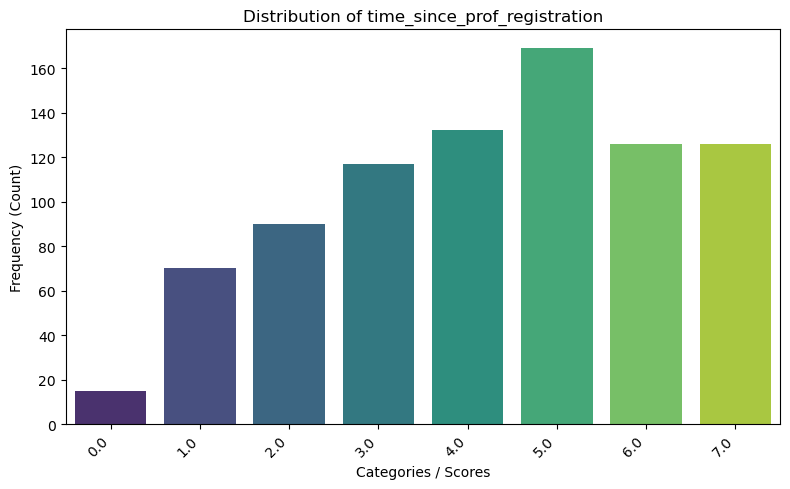

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


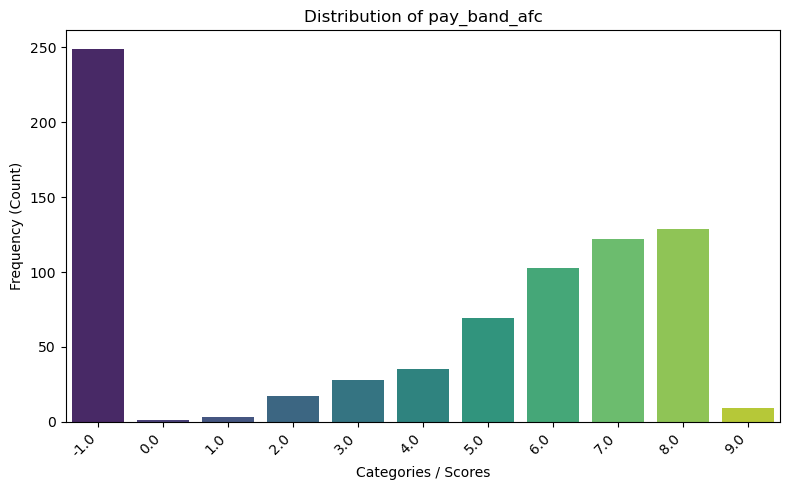

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


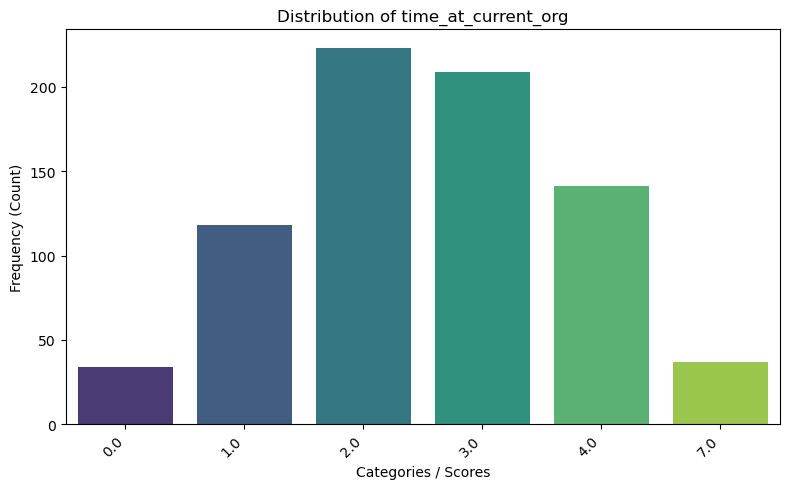

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


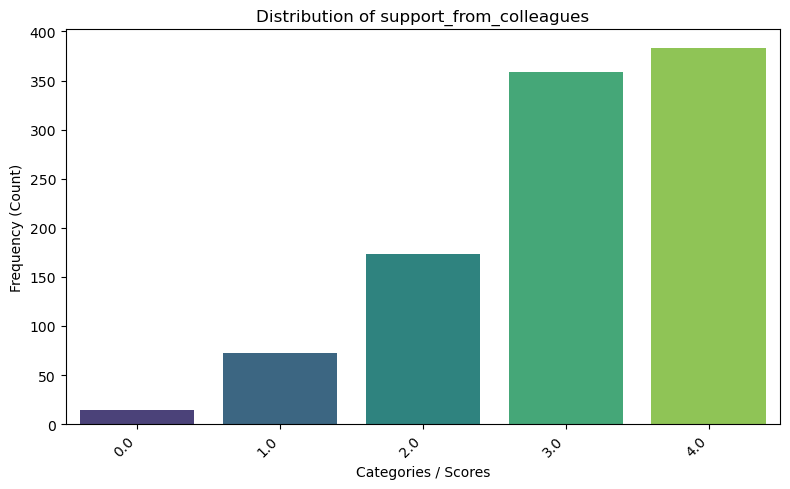

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


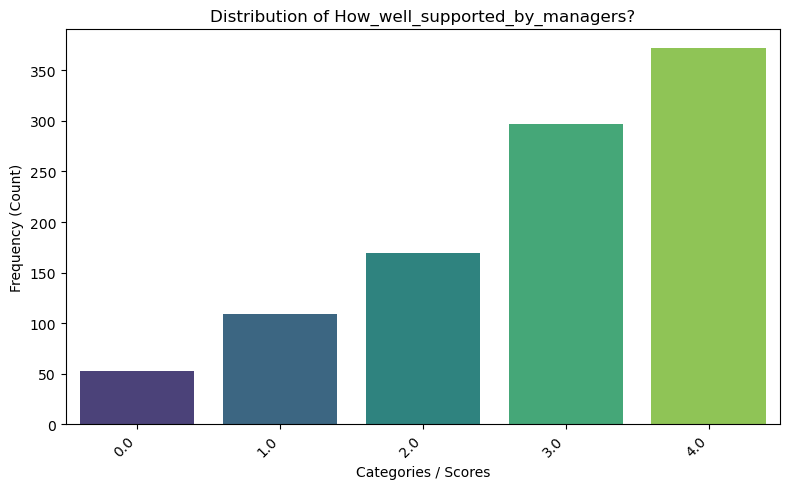

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


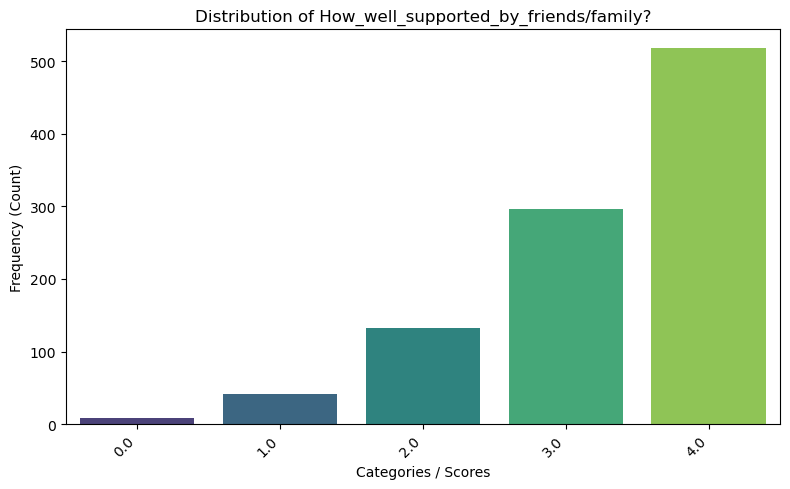

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


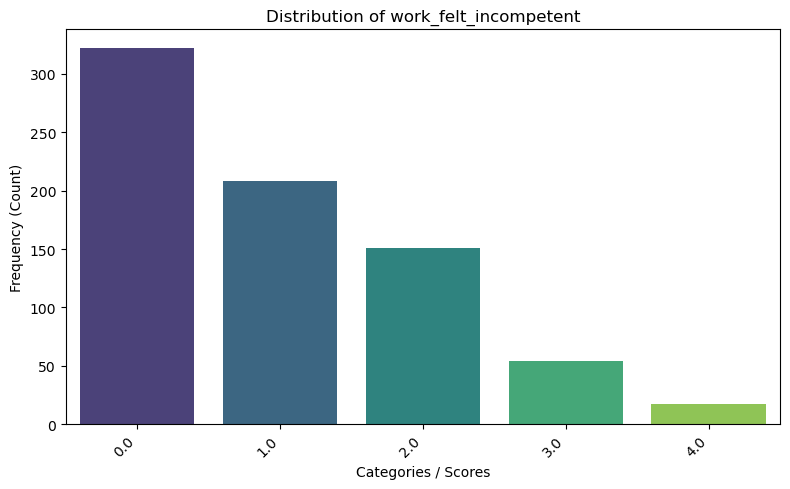

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


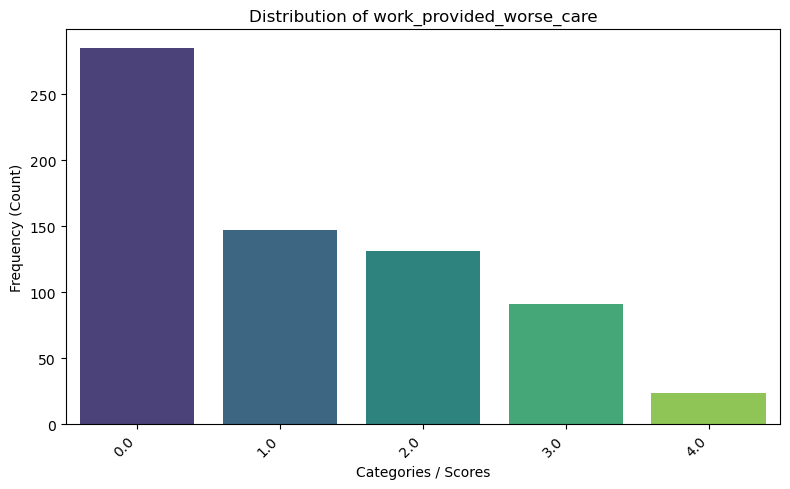

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


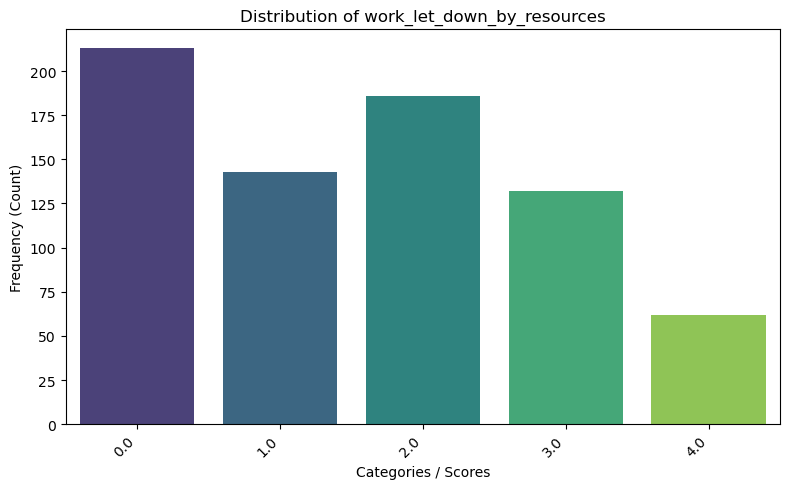

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


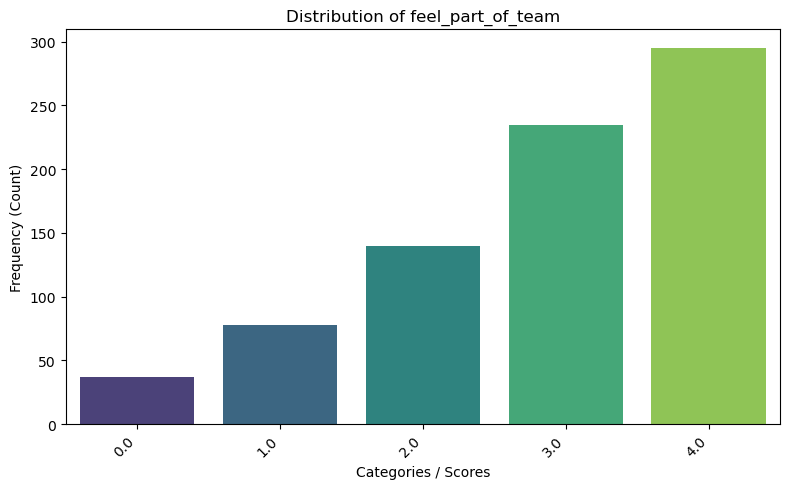

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


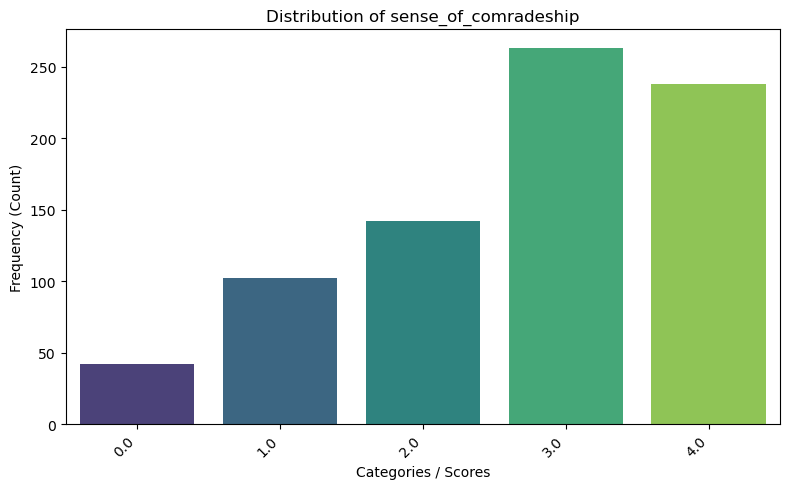

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


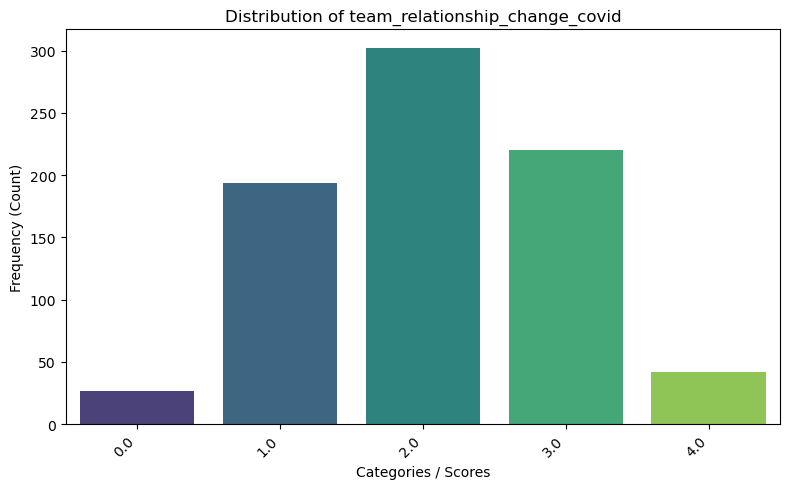

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


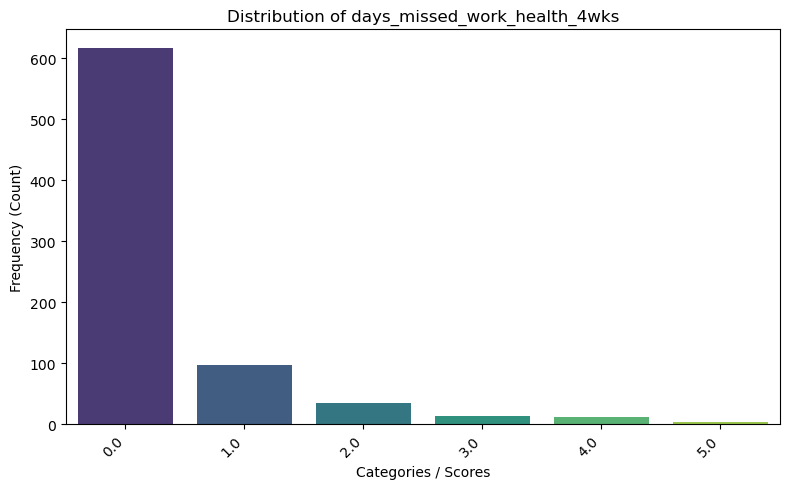

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


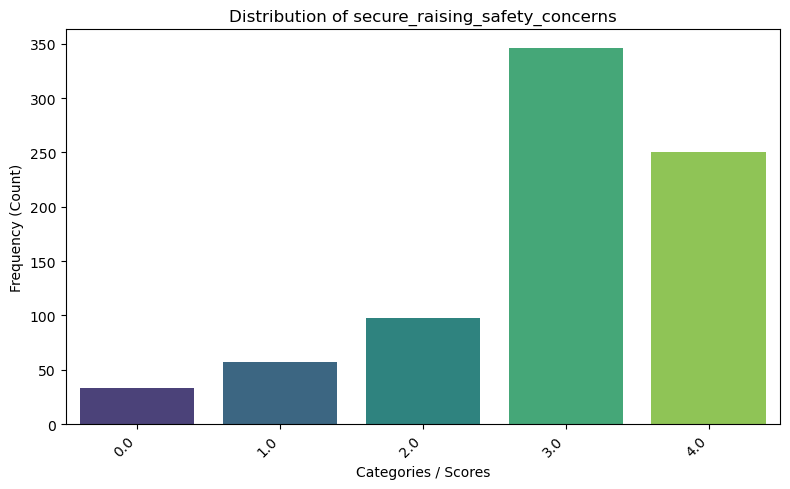

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


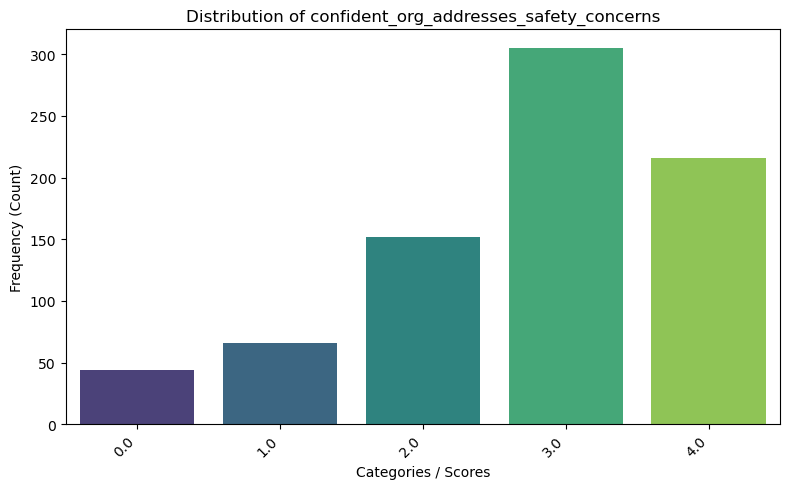

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


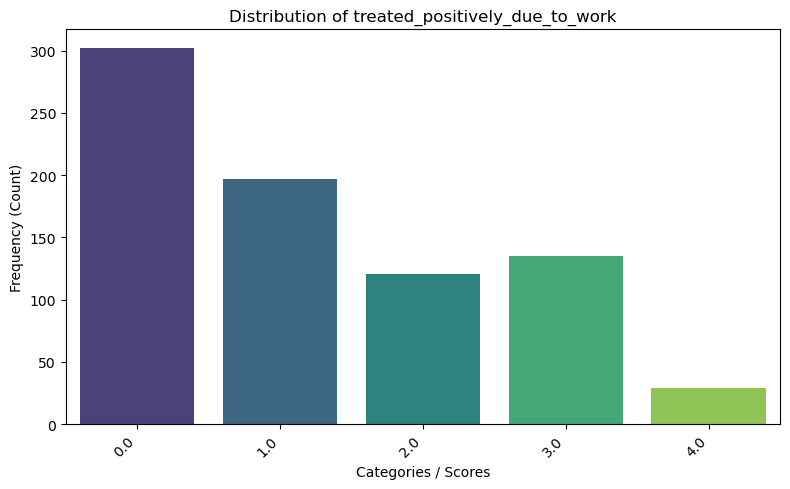

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


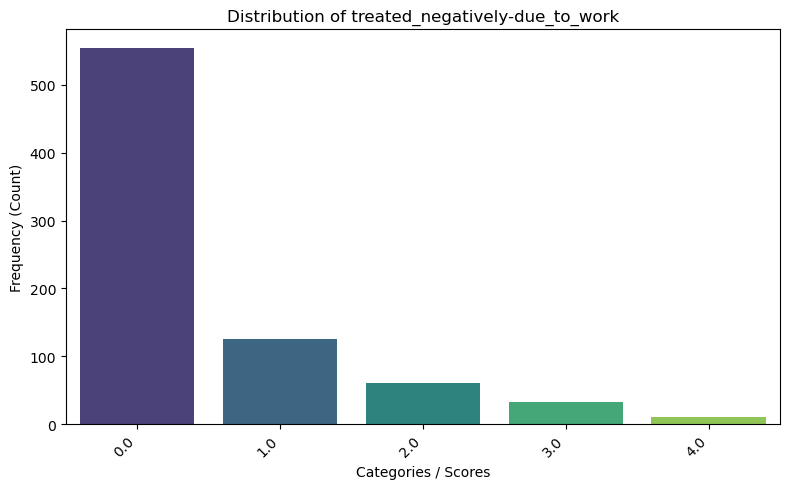

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


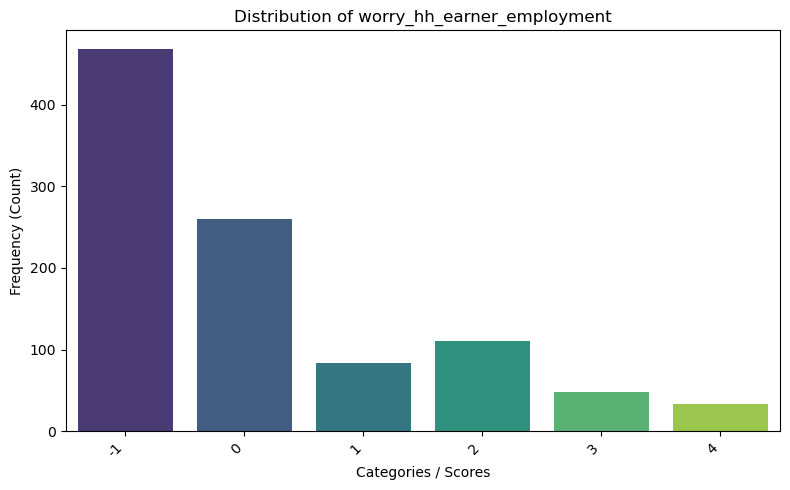

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


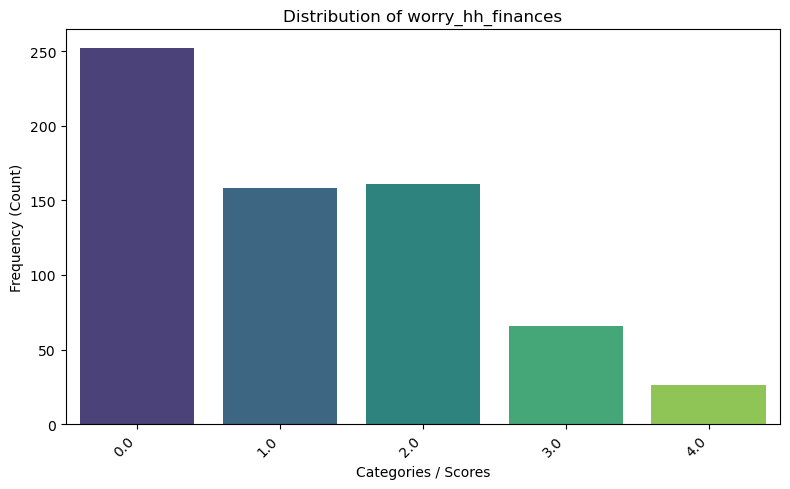

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


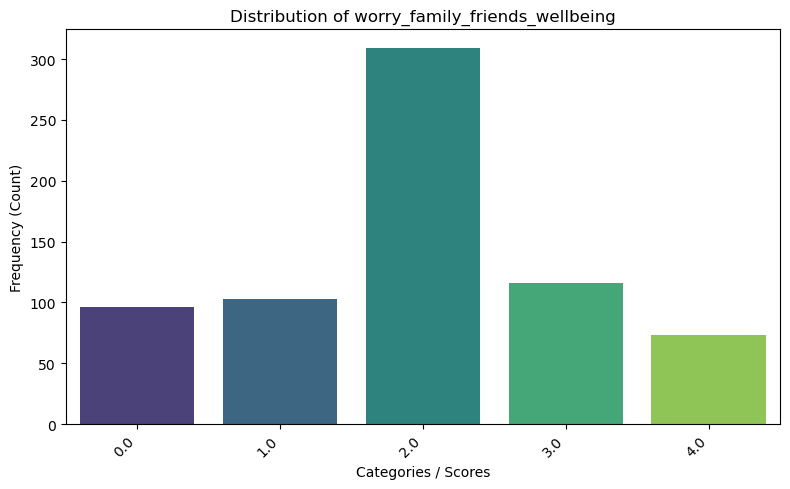

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


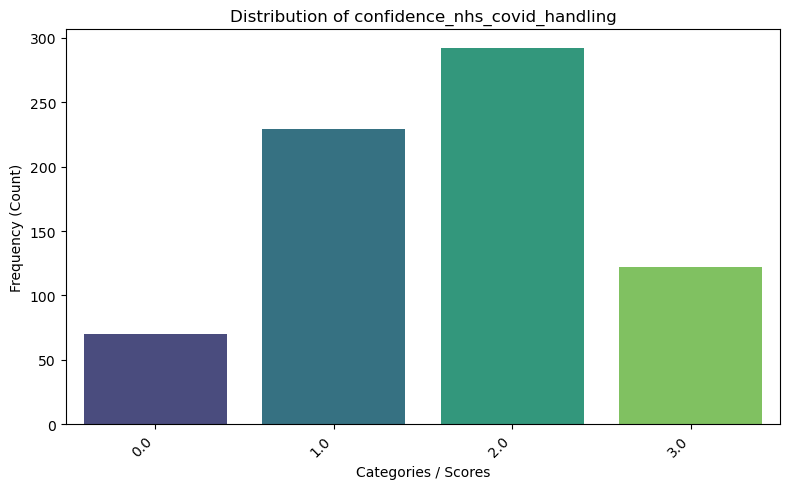

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


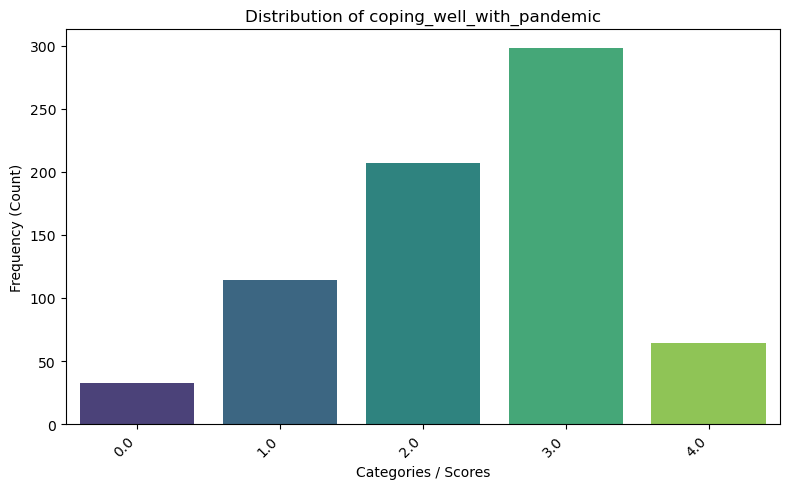

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


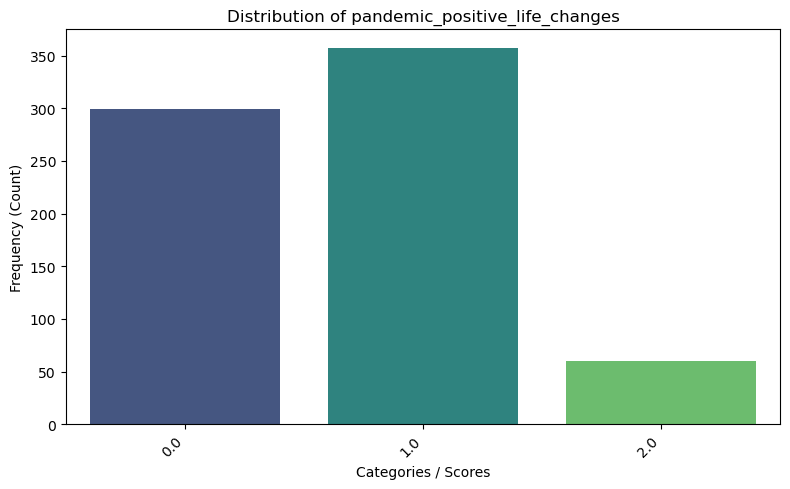

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


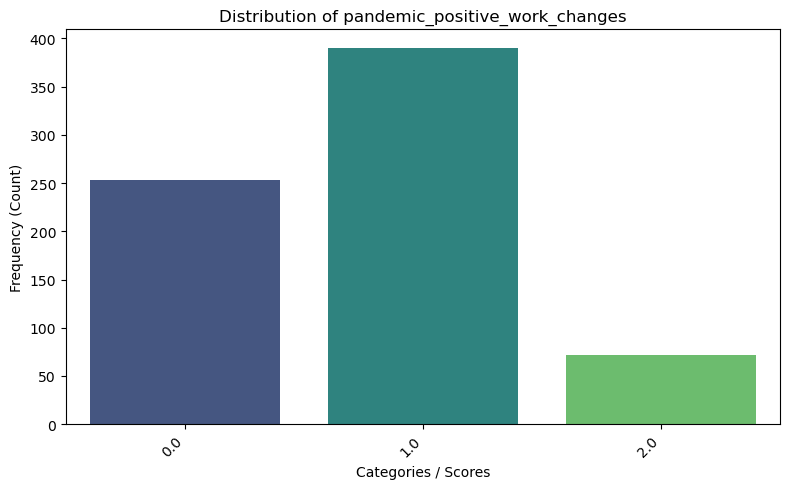

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


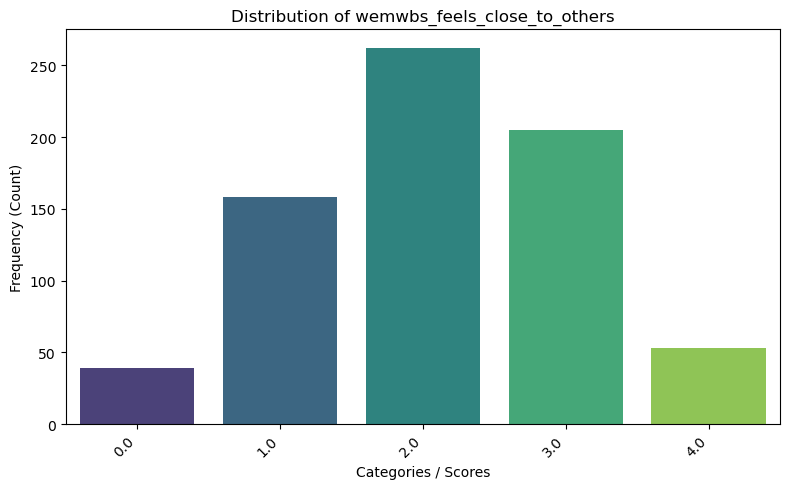

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


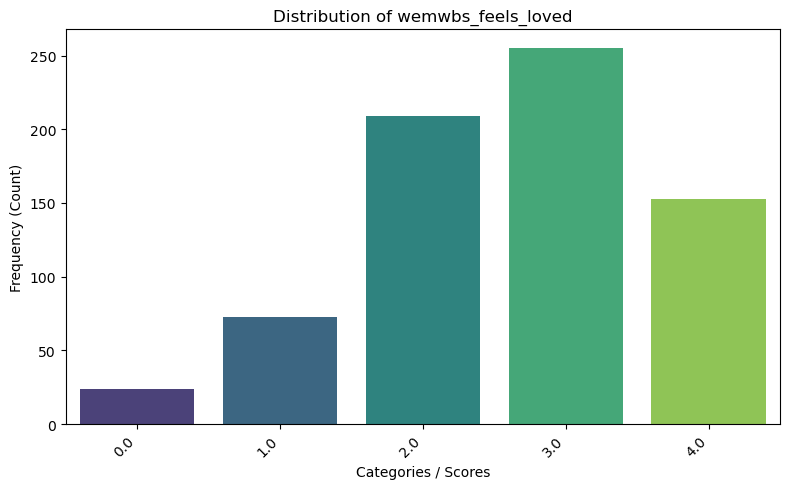

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


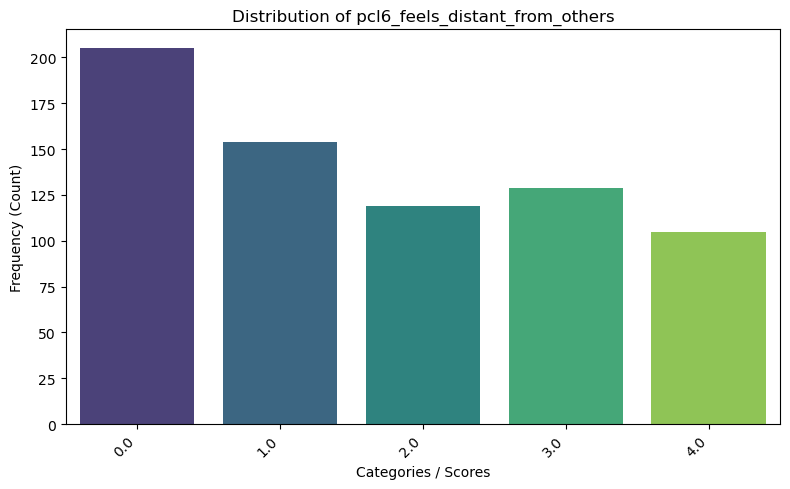

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


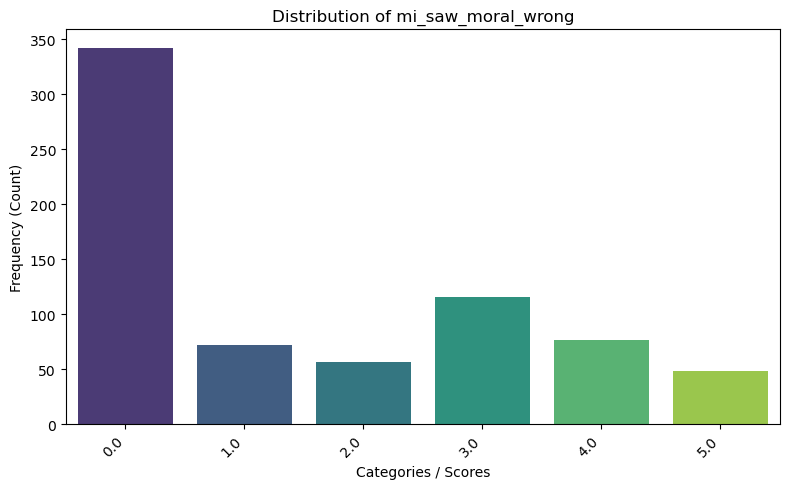

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


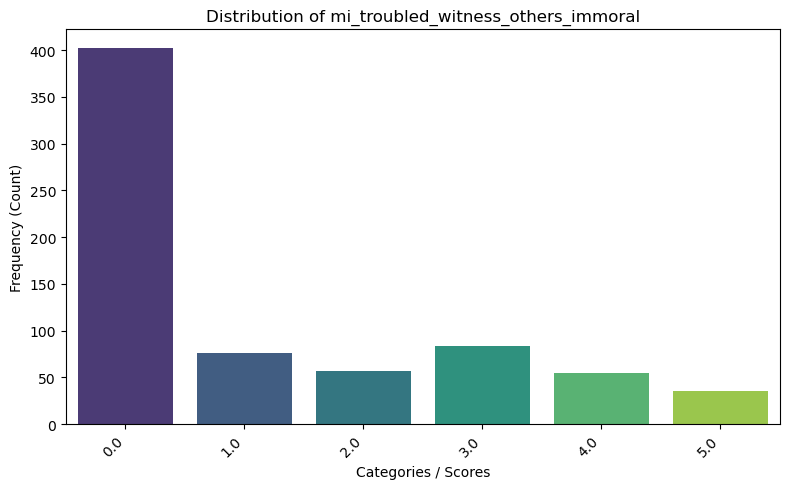

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


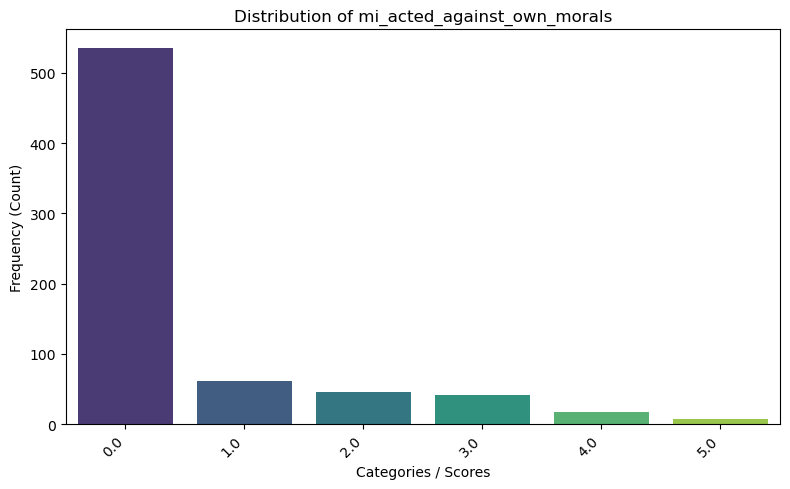

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


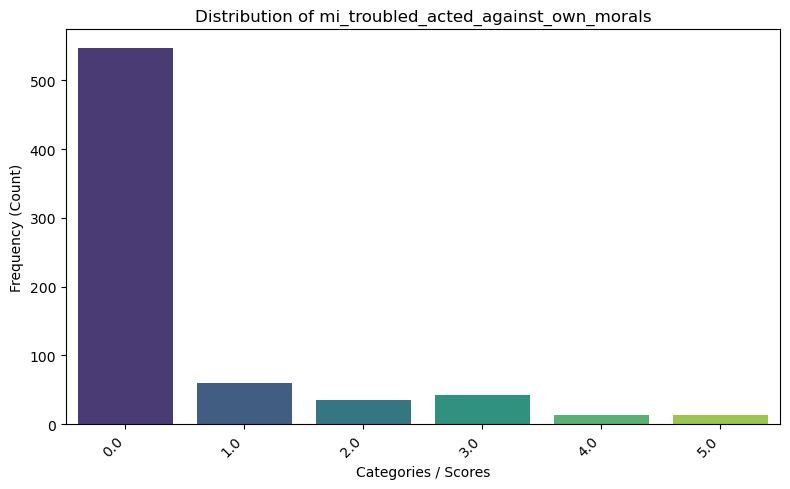

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


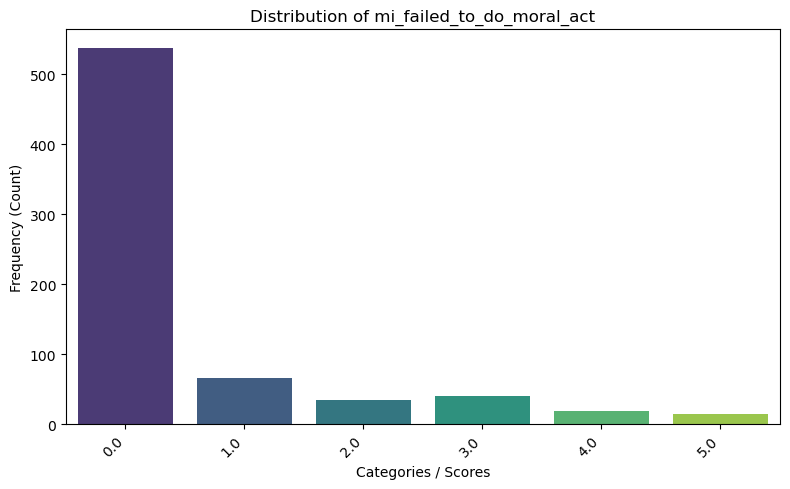

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


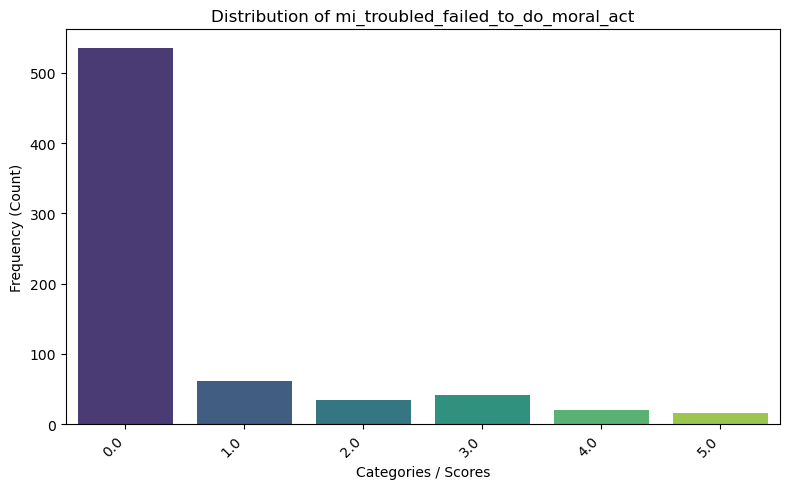

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


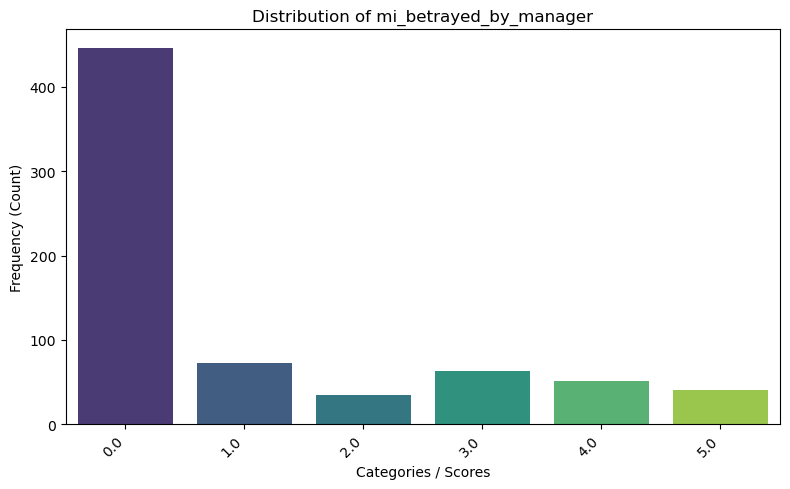

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


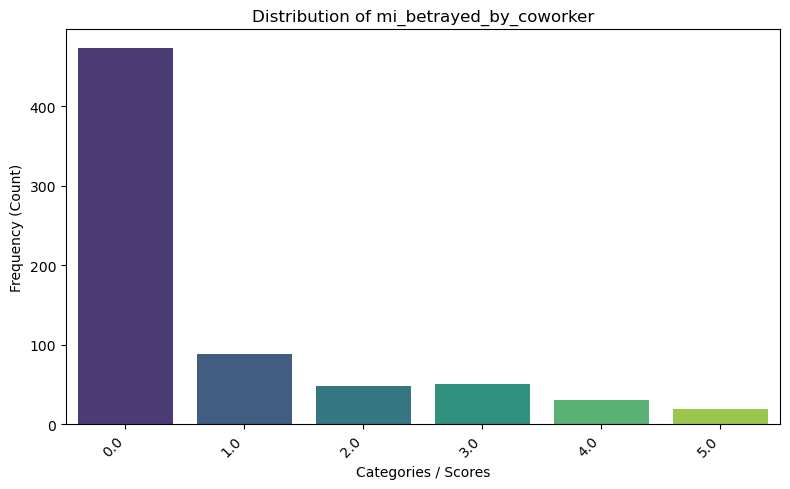

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


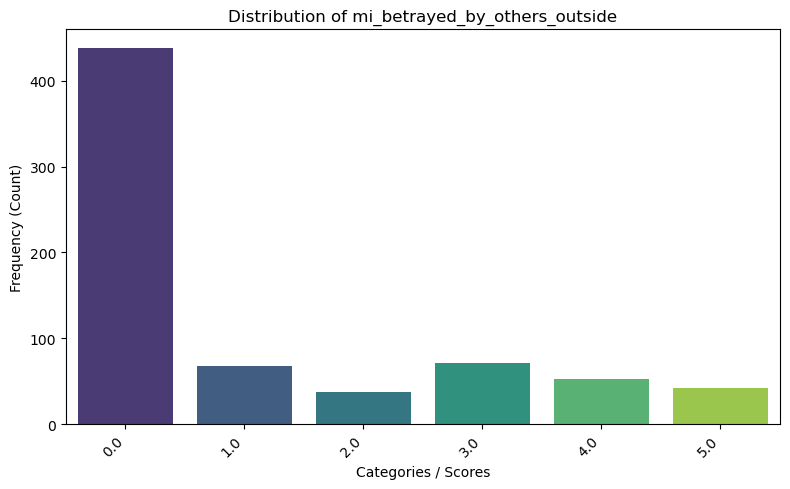

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


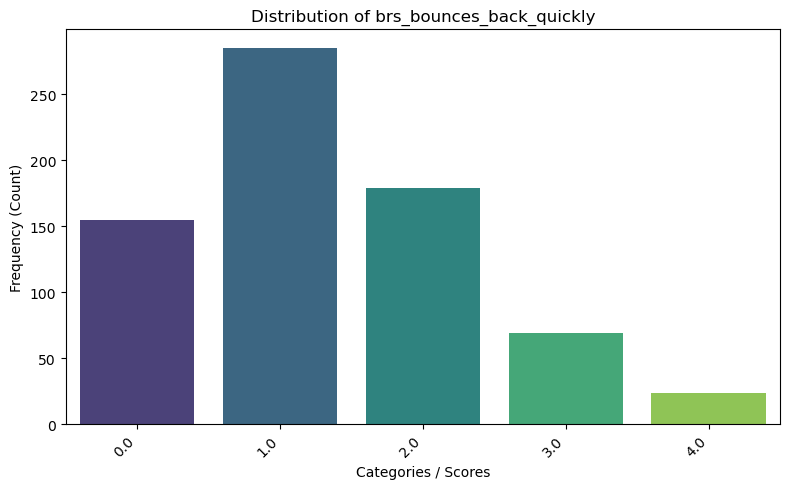

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


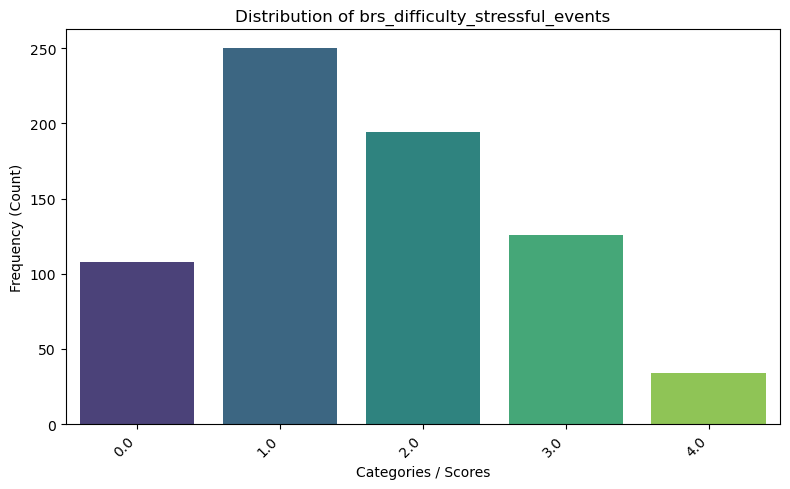

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


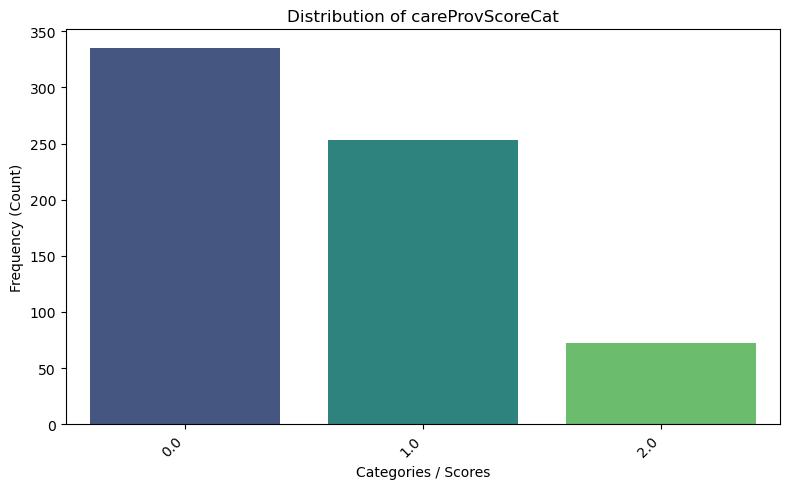

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/4046739501.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


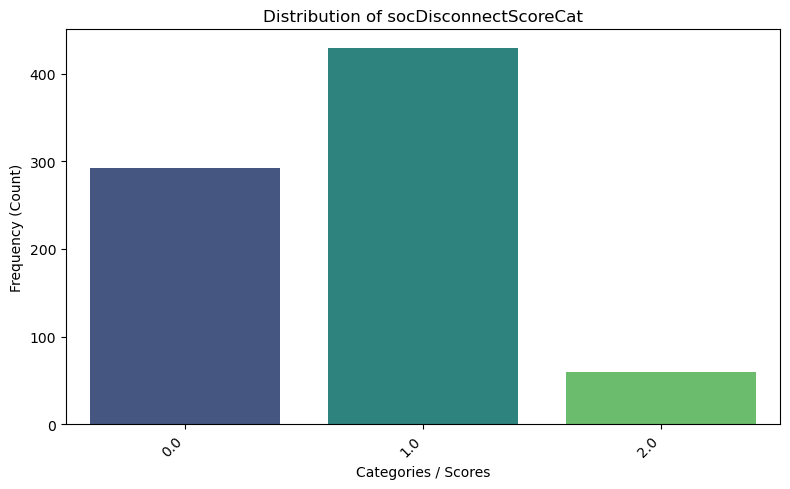

In [35]:

ordinal_feature_columns = [
    'time_since_prof_registration',
    'pay_band_afc',
    'time_at_current_org',
    'support_from_colleagues',
    'How_well_supported_by_managers?',
    'How_well_supported_by_friends/family?',
    'work_felt_incompetent',
    'work_provided_worse_care',
    'work_let_down_by_resources',
    'feel_part_of_team',
    'sense_of_comradeship',
    'team_relationship_change_covid',
    'days_missed_work_health_4wks',
    'secure_raising_safety_concerns',
    'confident_org_addresses_safety_concerns',
    'treated_positively_due_to_work',
    'treated_negatively-due_to_work',
    'worry_hh_earner_employment',
    'worry_hh_finances',
    'worry_family_friends_wellbeing',
    'confidence_nhs_covid_handling',
    'coping_well_with_pandemic',
    'pandemic_positive_life_changes',
    'pandemic_positive_work_changes',
    'wemwbs_feels_close_to_others',
    'wemwbs_feels_loved',
    'pcl6_feels_distant_from_others',
    'mi_saw_moral_wrong',
    'mi_troubled_witness_others_immoral',
    'mi_acted_against_own_morals',
    'mi_troubled_acted_against_own_morals',
    'mi_failed_to_do_moral_act',
    'mi_troubled_failed_to_do_moral_act',
    'mi_betrayed_by_manager',
    'mi_betrayed_by_coworker',
    'mi_betrayed_by_others_outside',
    'brs_bounces_back_quickly',
    'brs_difficulty_stressful_events',
    'careProvScoreCat', 
    'socDisconnectScoreCat' 
]

for col in ordinal_feature_columns:
    df_focused_converted[col].describe()

    # Plot bar chart of value counts for each feature
    plt.figure(figsize=(8, 5))
    value_counts = df_focused_converted[col].value_counts(dropna=False).sort_index()

    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
    plt.title(f"Distribution of {col}")
    plt.xlabel("Categories / Scores")
    plt.ylabel("Frequency (Count)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()




In [36]:
# define which columns to drop
columns_to_drop_low_variance = [
    'treated_negatively-due_to_work',
    'days_missed_work_health_4wks',
    'mi_saw_moral_wrong',
    'mi_troubled_witness_others_immoral',
    'mi_acted_against_own_morals',
    'mi_troubled_acted_against_own_morals',
    'mi_failed_to_do_moral_act',
    'mi_troubled_failed_to_do_moral_act',
    'mi_betrayed_by_manager',
    'mi_betrayed_by_coworker',
    'mi_betrayed_by_others_outside'
]

df_focused_converted.drop(columns=columns_to_drop_low_variance, inplace=True)


In [37]:
df_focused_converted.shape

(1004, 58)

#### Binary and Nominal Categorical data columns

<b>Dropping columns based on data imbalances</b>

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")



--- Feature: gender ---

Value Counts (Proportions):
gender
Female    0.750996
Male      0.243028
NaN       0.003984
Other     0.001992
Name: proportion, dtype: float64

Number of unique categories: 3


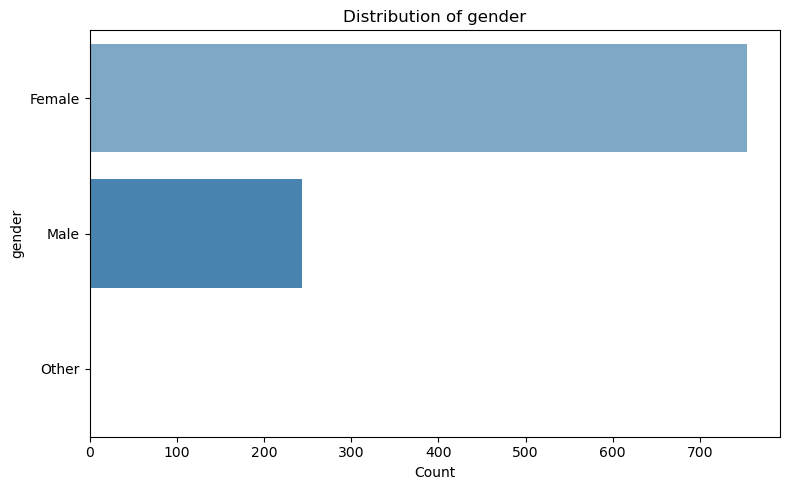


Skipping bivariate plot for gender as it contains NaN and requires imputation first.
--------------------------------------------------

--- Feature: relationship_status ---

Value Counts (Proportions):
relationship_status
Married / Civil partnership        0.471116
Single                             0.253984
Co-habiting / In a relationship    0.204183
Divorced / Separated               0.058765
Widowed                            0.008964
NaN                                0.002988
Name: proportion, dtype: float64

Number of unique categories: 5


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


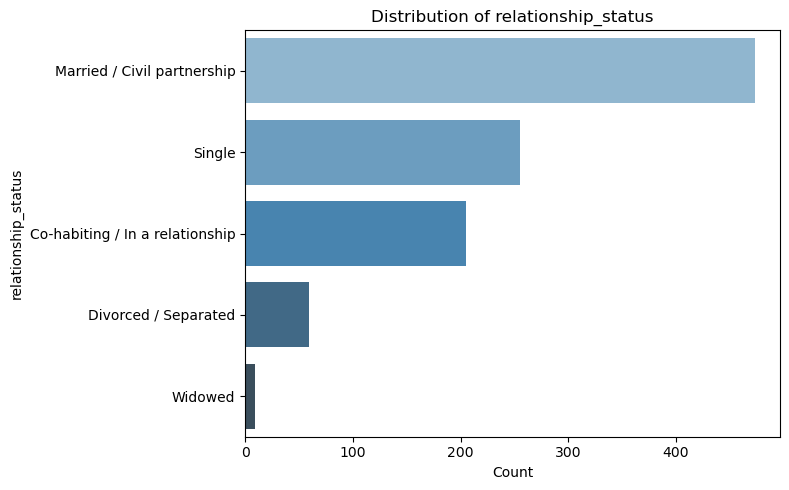


Skipping bivariate plot for relationship_status as it contains NaN and requires imputation first.
--------------------------------------------------

--- Feature: ethnic_group ---

Value Counts (Proportions):
ethnic_group
White English/Welsh/Scottish/Northern Irish/British    0.472112
Indian                                                 0.163347
Any other White background                             0.124502
Any other Asian background                             0.042829
White Irish                                            0.030876
Pakistani                                              0.026892
Any other ethnic group                                 0.023904
Black African                                          0.019920
Black Caribbean                                        0.018924
Any other Mixed/Multiple ethnic background             0.014940
Mixed White and Asian                                  0.013944
Chinese                                                0.013944
Arab     

/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


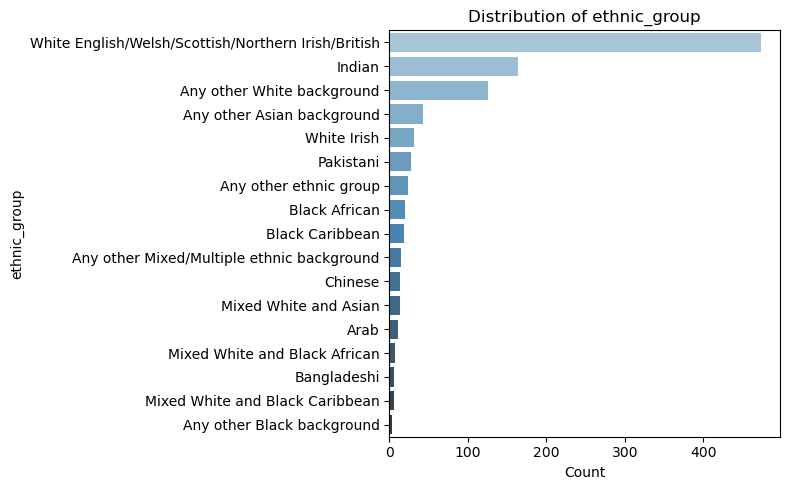


Skipping bivariate plot for ethnic_group as it contains NaN and requires imputation first.
--------------------------------------------------

--- Feature: birth_country_uk_eu_other ---

Value Counts (Proportions):
birth_country_uk_eu_other
United Kingdom                  0.635458
Other (please specify below)    0.254980
EU (not UK)                     0.103586
NaN                             0.005976
Name: proportion, dtype: float64

Number of unique categories: 3


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


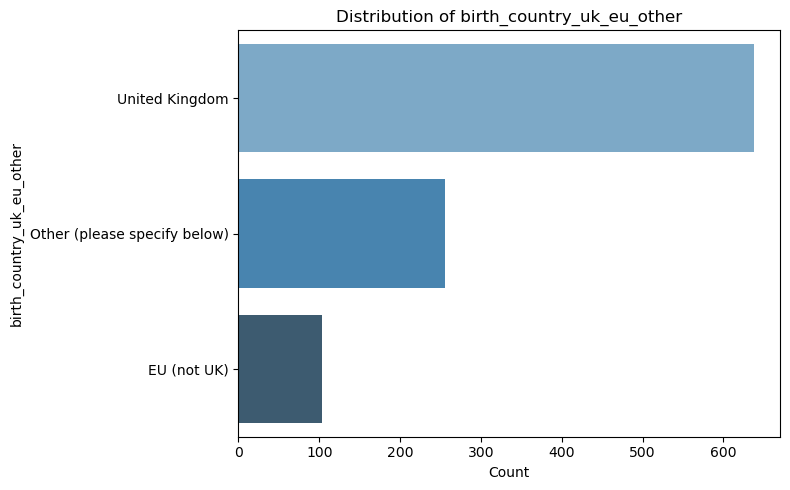


Skipping bivariate plot for birth_country_uk_eu_other as it contains NaN and requires imputation first.
--------------------------------------------------

--- Feature: role_type ---

Value Counts (Proportions):
role_type
Clinical        0.490040
Non-clinical    0.385458
Both            0.124502
Name: proportion, dtype: float64

Number of unique categories: 3


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


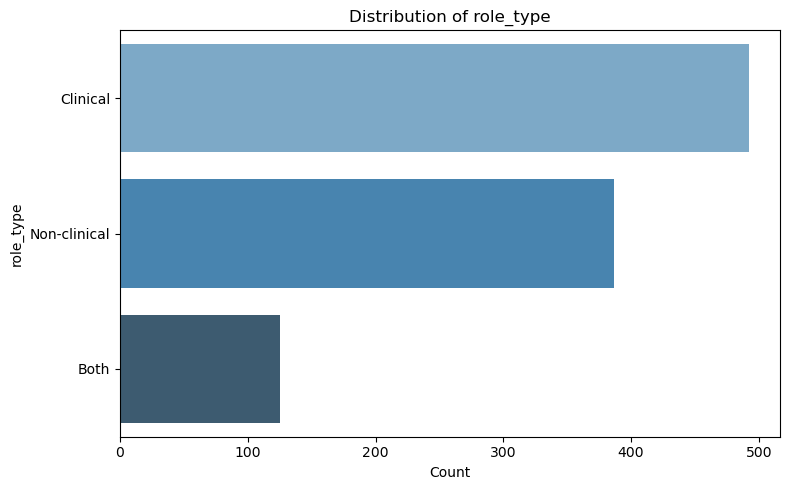


Relationship with Target (target_ghq_cmd_binary):
target_ghq_cmd_binary       0.0       1.0
role_type                                
Both                   0.432000  0.568000
Clinical               0.402439  0.597561
Non-clinical           0.540052  0.459948


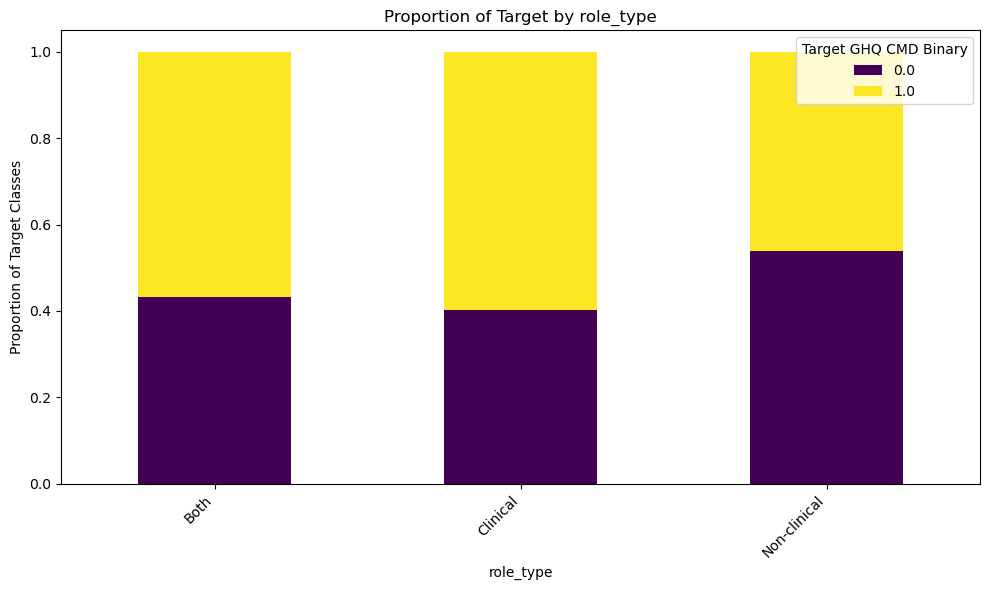

--------------------------------------------------

--- Feature: contract_type ---

Value Counts (Proportions):
contract_type
Yes                                   0.894422
Fixed-term contract                   0.045817
Locum/Bank/Agency/Shift/Contractor    0.032869
Training contract                     0.015936
Other                                 0.010956
Name: proportion, dtype: float64

Number of unique categories: 5


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


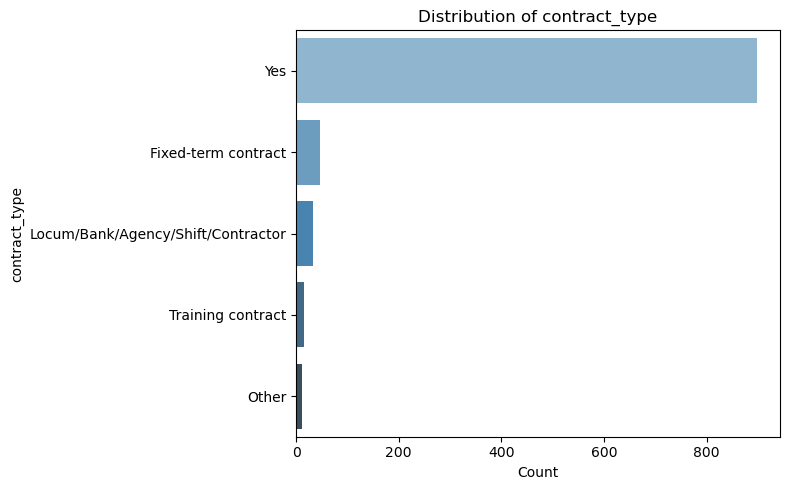


Relationship with Target (target_ghq_cmd_binary):
target_ghq_cmd_binary                    0.0       1.0
contract_type                                         
Fixed-term contract                 0.456522  0.543478
Locum/Bank/Agency/Shift/Contractor  0.606061  0.393939
Other                               0.545455  0.454545
Training contract                   0.375000  0.625000
Yes                                 0.454343  0.545657


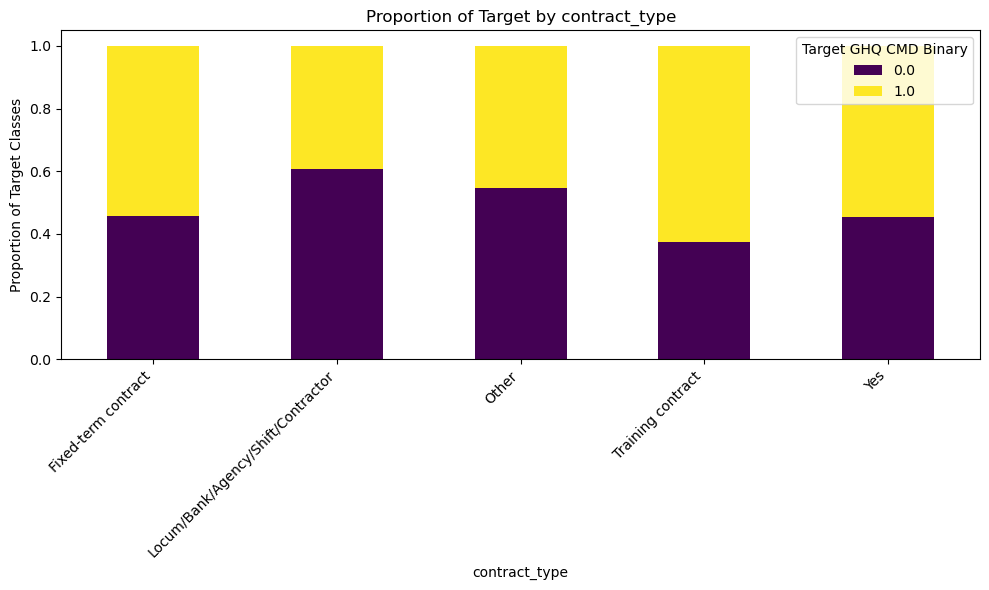

--------------------------------------------------

--- Feature: current_work_setting ---

Value Counts (Proportions):
current_work_setting
Non-acute    0.507968
Acute        0.492032
Name: proportion, dtype: float64

Number of unique categories: 2


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


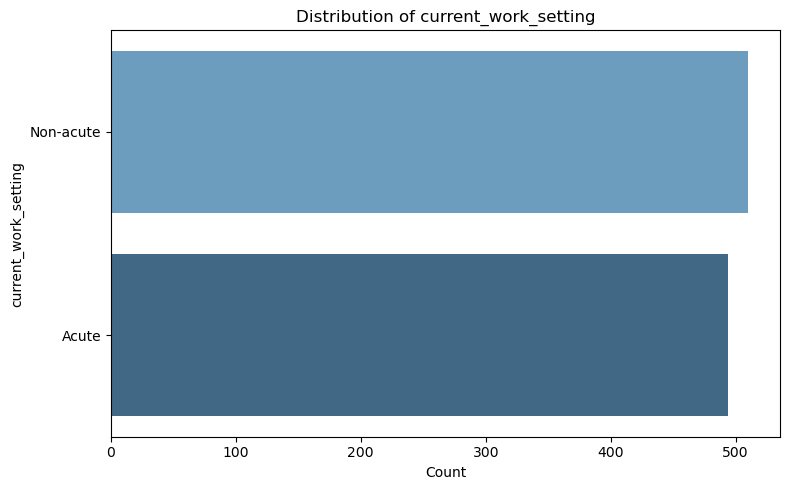


Relationship with Target (target_ghq_cmd_binary):
target_ghq_cmd_binary       0.0       1.0
current_work_setting                     
Acute                  0.344130  0.655870
Non-acute              0.570588  0.429412


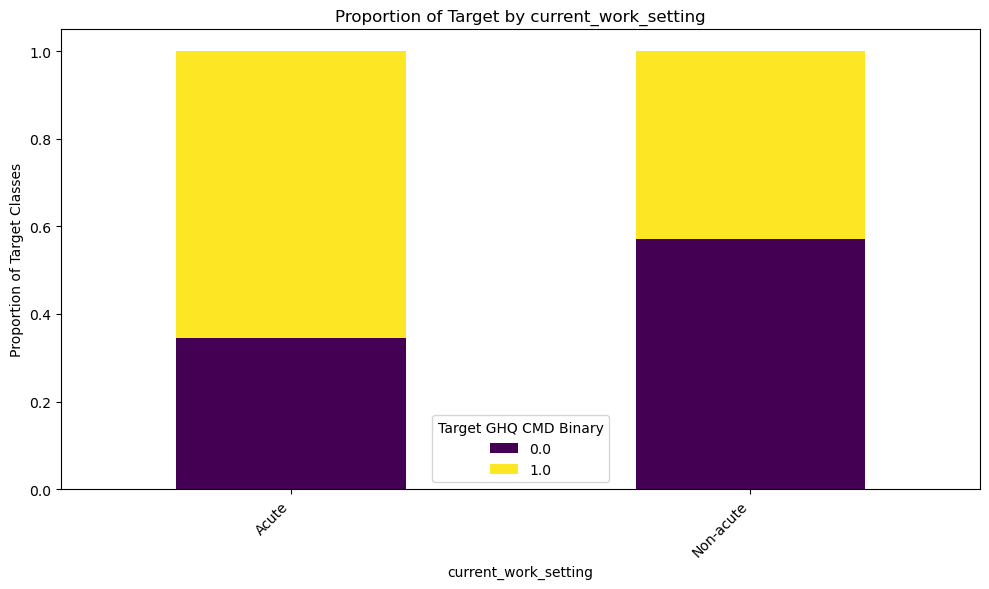

--------------------------------------------------

--- Feature: contact_suspected_covid_work ---

Value Counts (Proportions):
contact_suspected_covid_work
Yes    0.628486
No     0.243028
NaN    0.128486
Name: proportion, dtype: float64

Number of unique categories: 2


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


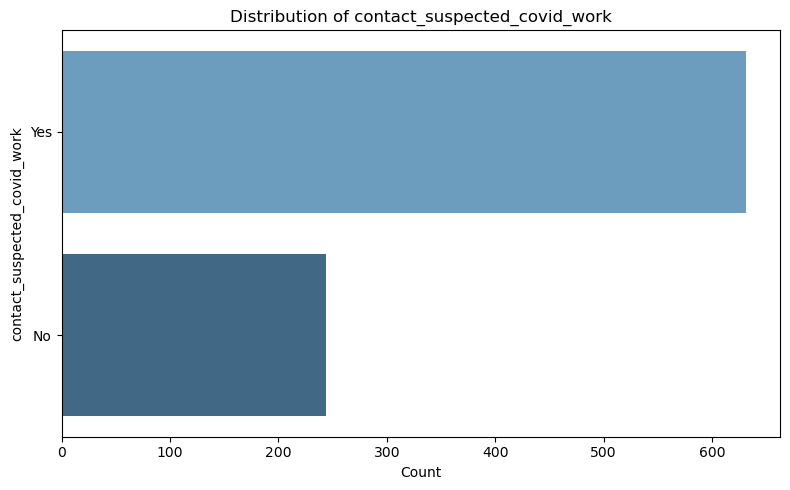


Skipping bivariate plot for contact_suspected_covid_work as it contains NaN and requires imputation first.
--------------------------------------------------

--- Feature: Full_time/part_time ---

Value Counts (Proportions):
Full_time/part_time
 1    0.471116
-1    0.401394
 0    0.127490
Name: proportion, dtype: float64

Number of unique categories: 3


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1390337749.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")


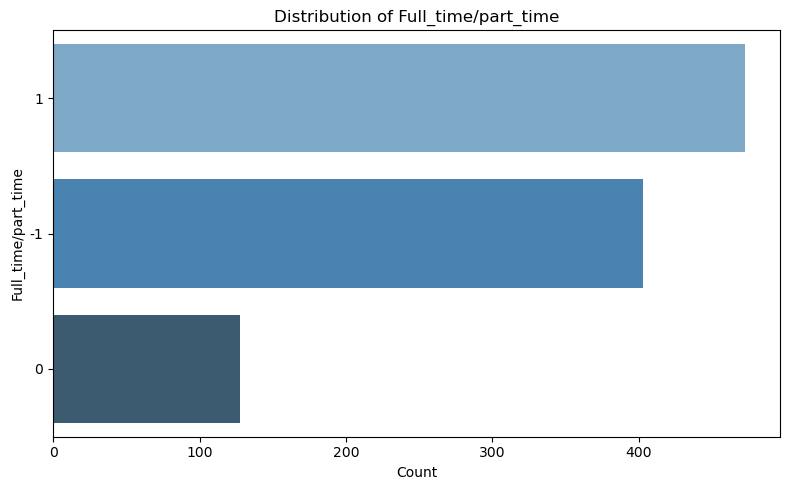


Relationship with Target (target_ghq_cmd_binary):
target_ghq_cmd_binary       0.0       1.0
Full_time/part_time                      
-1                     0.496278  0.503722
 0                     0.539062  0.460938
 1                     0.405920  0.594080


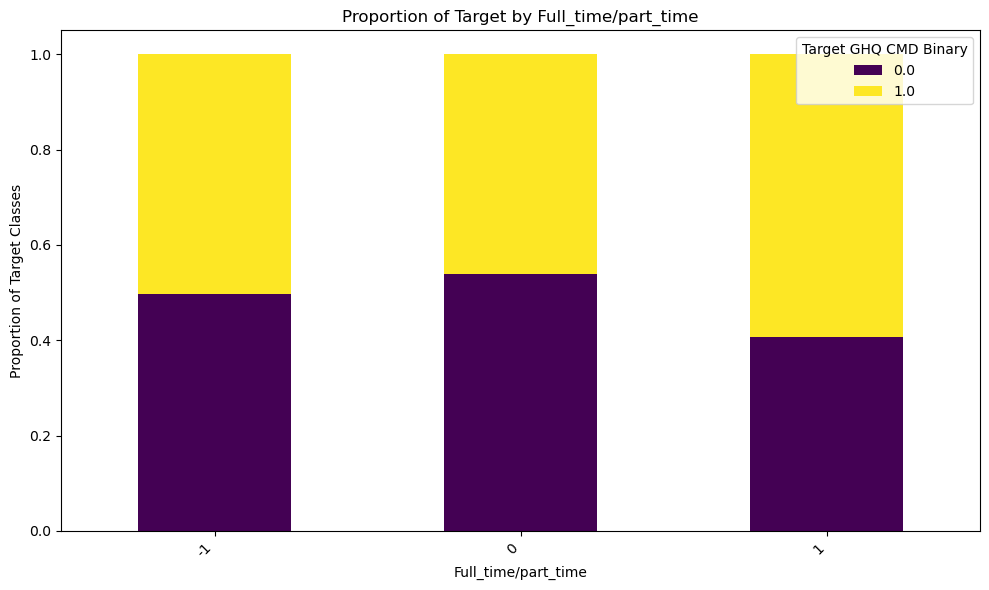

--------------------------------------------------


In [38]:

nominal_categorical_features = [
    'gender',
    'relationship_status',
    'ethnic_group',
    'birth_country_uk_eu_other',
    'role_type',
    'contract_type',
    'current_work_setting',
    'contact_suspected_covid_work',
    'Full_time/part_time'
]


for col in nominal_categorical_features:
 
    print(f"\n--- Feature: {col} ---")
    
    # Value counts (including NaNs if any remain, though ideally imputed by now)
    print("\nValue Counts (Proportions):")
    print(df_focused_converted[col].value_counts(normalize=True, dropna=False))
    
    print(f"\nNumber of unique categories: {df_focused_converted[col].nunique(dropna=True)}")

    # Bar chart of each feature's distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_focused_converted, y=col, order=df_focused_converted[col].value_counts().index, palette="Blues_d")
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Bivariate: Feature vs. Target
    # Crosstab showing proportions of target for each category of the feature
    if df_focused_converted[col].isnull().sum() == 0: # Ensure no NaNs for crosstab which it can't use
        print("\nRelationship with Target (target_ghq_cmd_binary):")
        crosstab_norm = pd.crosstab(df_focused_converted[col], df_focused_converted['target_ghq_cmd_binary'], normalize='index')
        print(crosstab_norm)
        
        crosstab_norm.plot(kind='bar', stacked=True, figsize=(10,6), colormap="viridis")
        plt.title(f"Proportion of Target by {col}")
        plt.ylabel("Proportion of Target Classes")
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Target GHQ CMD Binary')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nSkipping bivariate plot for {col} as it contains NaN and requires imputation first.")
    print("-" * 50)



<b>Conclusion of nominal categorical univariate/bivariate EDA:</b> It hasn't indicated any features that definitely need dropping. 'ethnic_group' is very imbalanced, however it is a standard psychosocial metric, and without bivariate analysis (I haven't imputed this column yet) I can't be sure that it doesn't have discriminative power.

let's move to binary columns.


--- Feature: is_student ---

Value Counts (Proportions):
is_student
0.0    0.969124
1.0    0.028884
NaN    0.001992
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


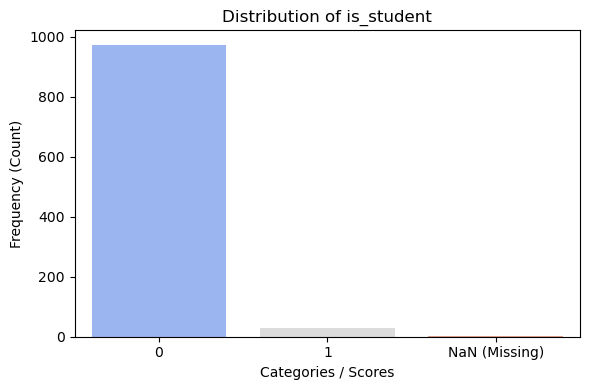


Skipping bivariate plot for is_student due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: is_volunteer ---

Value Counts (Proportions):
is_volunteer
0.0    0.989044
NaN    0.005976
1.0    0.004980
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


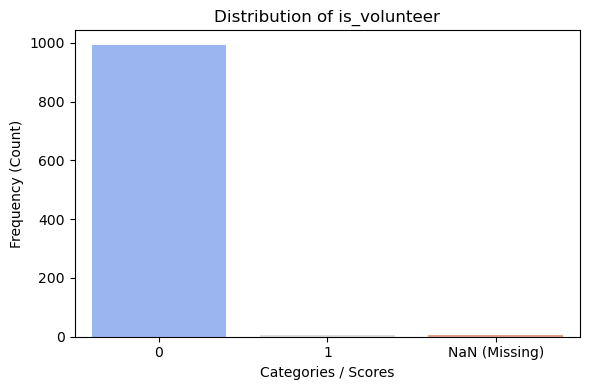


Skipping bivariate plot for is_volunteer due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: Isolating/isolated_covid ---

Value Counts (Proportions):
Isolating/isolated_covid
0.0    0.706175
1.0    0.289841
NaN    0.003984
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


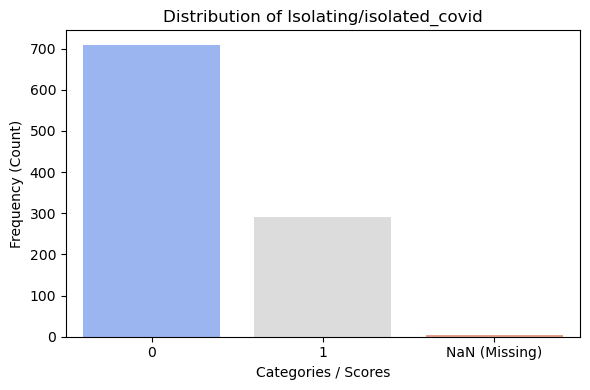


Skipping bivariate plot for Isolating/isolated_covid due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: self_is_at_risk_group_covid ---

Value Counts (Proportions):
self_is_at_risk_group_covid
0.0    0.560757
NaN    0.283865
1.0    0.155378
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


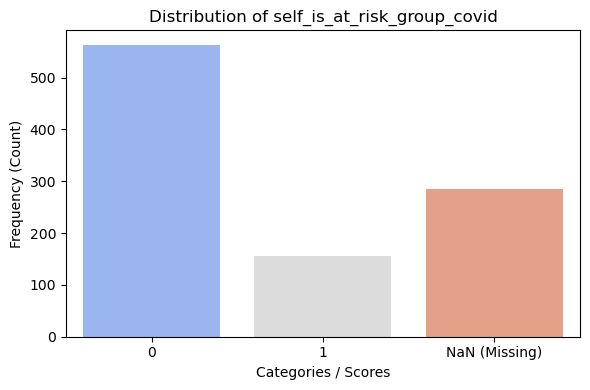


Skipping bivariate plot for self_is_at_risk_group_covid due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: hh_member_is_at_risk_covid ---

Value Counts (Proportions):
hh_member_is_at_risk_covid
0.0    0.496016
NaN    0.284861
1.0    0.219124
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


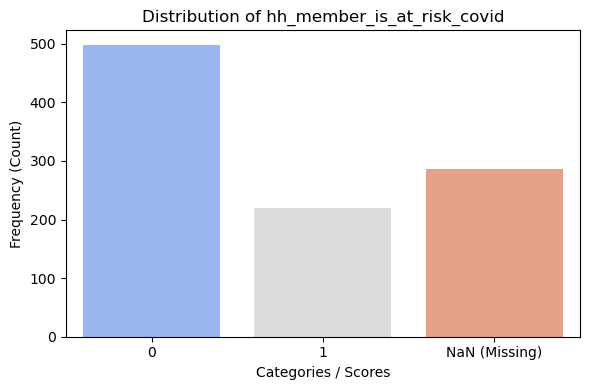


Skipping bivariate plot for hh_member_is_at_risk_covid due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: has_children_u18 ---

Value Counts (Proportions):
has_children_u18
0.0    0.528884
NaN    0.282869
1.0    0.188247
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


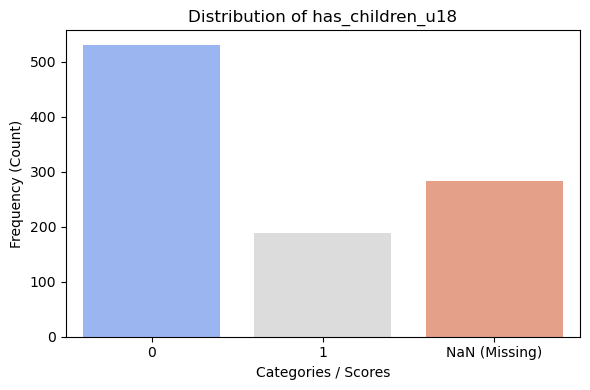


Skipping bivariate plot for has_children_u18 due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: has_other_dependents ---

Value Counts (Proportions):
has_other_dependents
0.0    0.547809
NaN    0.285857
1.0    0.166335
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


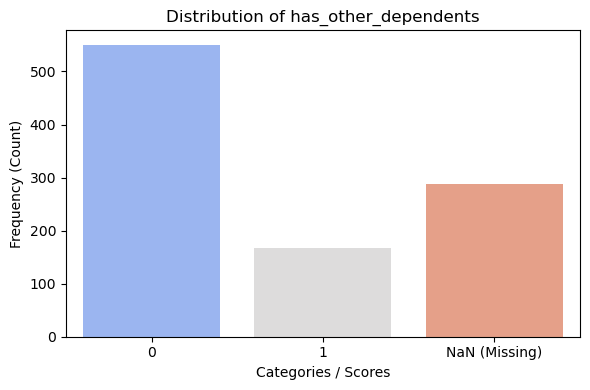


Skipping bivariate plot for has_other_dependents due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: knows_someone_died_covid_outside_work ---

Value Counts (Proportions):
knows_someone_died_covid_outside_work
0.0    0.400398
1.0    0.316733
NaN    0.282869
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


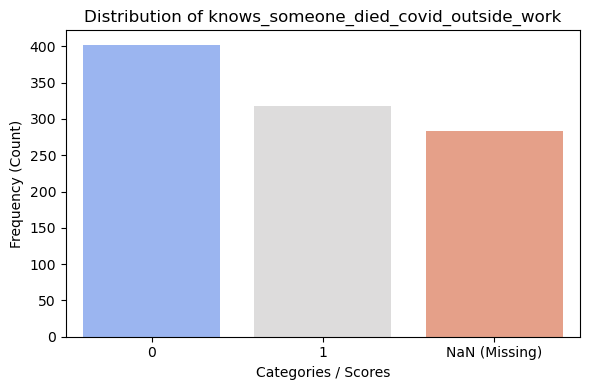


Skipping bivariate plot for knows_someone_died_covid_outside_work due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: colleague_died_covid ---

Value Counts (Proportions):
colleague_died_covid
0.0    0.557769
NaN    0.284861
1.0    0.157371
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


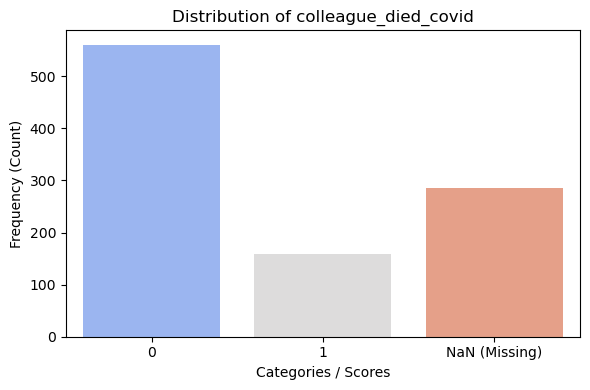


Skipping bivariate plot for colleague_died_covid due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: is_primary_care_worker ---

Value Counts (Proportions):
is_primary_care_worker
1    0.507968
0    0.492032
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


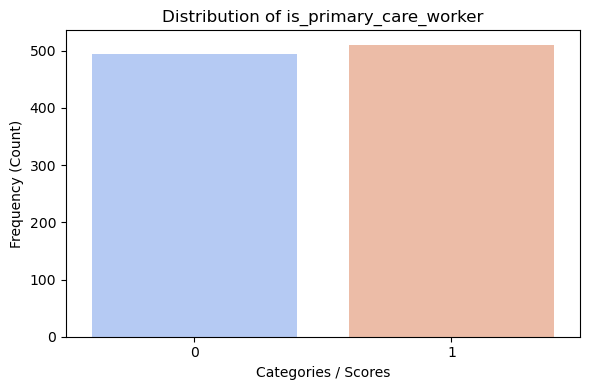


Relationship with Target (target_ghq_cmd_binary):
target_ghq_cmd_binary        0.0       1.0
is_primary_care_worker                    
0                       0.344130  0.655870
1                       0.570588  0.429412


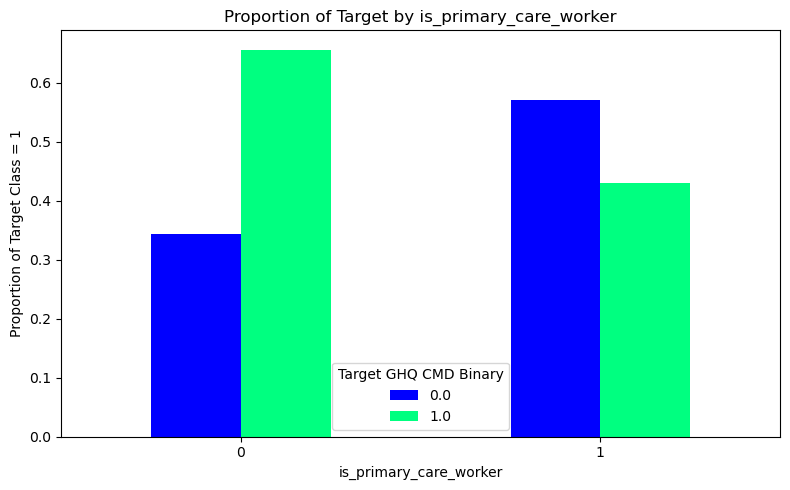

--------------------------------------------------

--- Feature: used_support_service ---

Value Counts (Proportions):
used_support_service
1    0.695219
0    0.304781
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


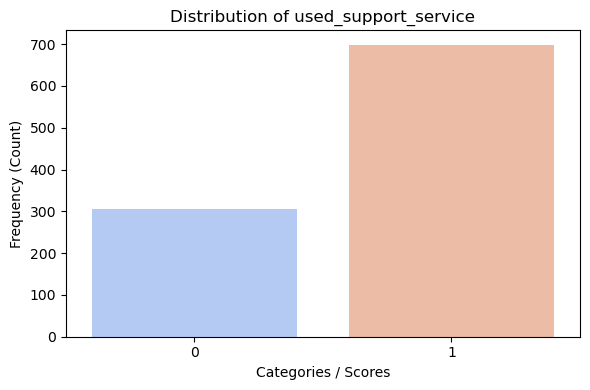


Relationship with Target (target_ghq_cmd_binary):
target_ghq_cmd_binary       0.0       1.0
used_support_service                     
0                      0.388889  0.611111
1                      0.489971  0.510029


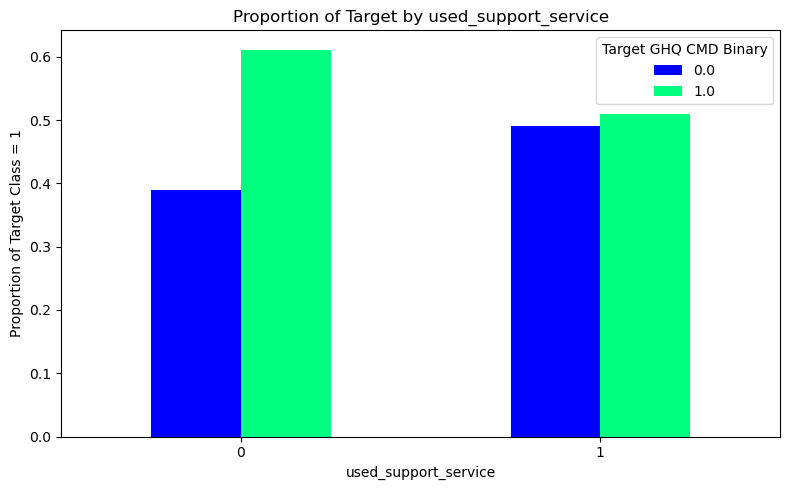

--------------------------------------------------

--- Feature: probable_aud ---

Value Counts (Proportions):
probable_aud
0.0    0.627490
NaN    0.296813
1.0    0.075697
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


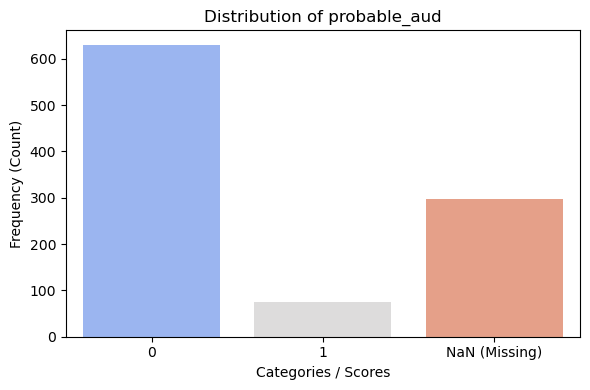


Skipping bivariate plot for probable_aud due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: probable_gad ---

Value Counts (Proportions):
probable_gad
0.0    0.520916
NaN    0.293825
1.0    0.185259
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


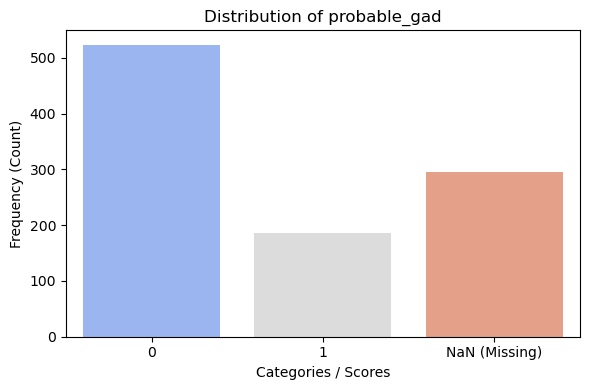


Skipping bivariate plot for probable_gad due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: probable_phq ---

Value Counts (Proportions):
probable_phq
0.0    0.492032
NaN    0.294821
1.0    0.213147
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


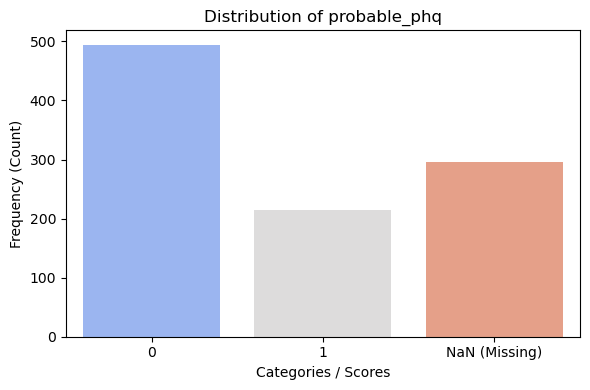


Skipping bivariate plot for probable_phq due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: probable_bat ---

Value Counts (Proportions):
probable_bat
0.0    0.470120
NaN    0.314741
1.0    0.215139
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


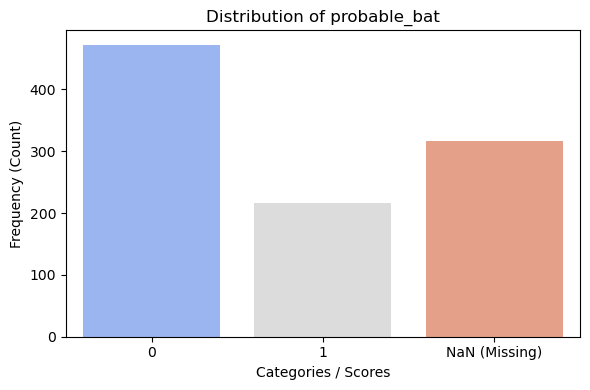


Skipping bivariate plot for probable_bat due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------

--- Feature: probable_pcl ---

Value Counts (Proportions):
probable_pcl
0.0    0.500996
NaN    0.295817
1.0    0.203187
Name: proportion, dtype: float64


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/463988587.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)


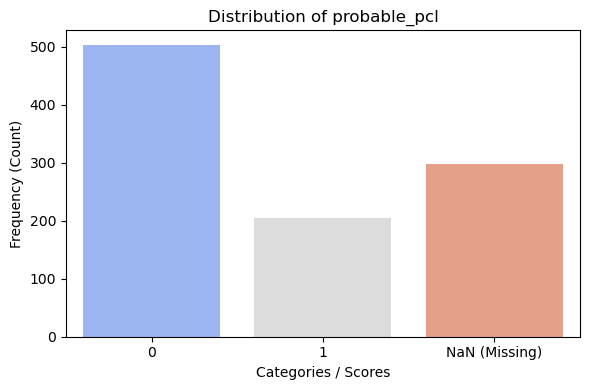


Skipping bivariate plot for probable_pcl due to NaNs in feature (hasn't been imputed yet).
--------------------------------------------------


In [39]:

binary_features = [
    'is_student',
    'is_volunteer',
    'Isolating/isolated_covid',
    'self_is_at_risk_group_covid',
    'hh_member_is_at_risk_covid',
    'has_children_u18',
    'has_other_dependents',
    'knows_someone_died_covid_outside_work',
    'colleague_died_covid',
    'is_primary_care_worker',
    'used_support_service',
    'probable_aud',
    'probable_gad',
    'probable_phq',
    'probable_bat',
    'probable_pcl'
]


for col in binary_features:

    print(f"\n--- Feature: {col} ---")

    # visualise by value counts (including NaNs)
    print("\nValue Counts (Proportions):")
    print(df_focused_converted[col].value_counts(normalize=True, dropna=False))

    # Bar chart of the feature's distribution
    plt.figure(figsize=(6, 4))
    counts = df_focused_converted[col].value_counts(dropna=False).sort_index()
    x_labels_bin = []
    for idx_val in counts.index:
        if pd.isna(idx_val):
            x_labels_bin.append("NaN (Missing)")
        else:
            x_labels_bin.append(str(int(idx_val)) if isinstance(idx_val, float) and idx_val.is_integer() else str(idx_val))
            
    sns.barplot(x=x_labels_bin, y=counts.values, palette="coolwarm", order=x_labels_bin)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Categories / Scores")
    plt.ylabel("Frequency (Count)")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Bivariate: Feature vs. Target
    if df_focused_converted[col].isnull().sum() == 0:
        print("\nRelationship with Target (target_ghq_cmd_binary):")
        crosstab_norm_bin = pd.crosstab(df_focused_converted[col], df_focused_converted['target_ghq_cmd_binary'], normalize='index')
        print(crosstab_norm_bin)

        crosstab_norm_bin.plot(kind='bar', stacked=False, figsize=(8,5), colormap="winter")
        plt.title(f"Proportion of Target by {col}")
        plt.ylabel("Proportion of Target Class = 1")
        plt.xticks(rotation=0)
        plt.legend(title='Target GHQ CMD Binary')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nSkipping bivariate plot for {col} due to NaNs in feature (hasn't been imputed yet).")
    print("-" * 50)



<b>Conclusions from binary univariate/bivariate analysis:</b> The imbalances in data in these binary columns are slightly more telling. 

Based on data imbalances, these columns will be dropped:

* is_student
* is_volunteer

In [40]:
# Columns to drop
columns_to_drop_imbalanced = [
    'is_student',
    'is_volunteer'
]

df_focused_converted.drop(columns=columns_to_drop_imbalanced, inplace=True)


## 4. Feature Engineering and Selection

### 4.1 Data imputation

In [41]:


df_focused_imputed = df_focused_converted.copy()


print(f"Created df_focused_imputed. Shape before imputation: {df_focused_imputed.shape}")
print(f"Total NaNs in df_focused_imputed before imputation: {df_focused_imputed.isnull().sum().sum()}")


numerical_ordinal_cols_to_impute = [
    'age', 'pay_band_afc', 'time_since_prof_registration', 'time_at_current_org',
    'support_from_colleagues', 'How_well_supported_by_managers?',
    'How_well_supported_by_friends/family?', 'work_felt_incompetent',
    'work_provided_worse_care', 'work_let_down_by_resources',
    'feel_part_of_team', 'sense_of_comradeship', 'team_relationship_change_covid',
    'secure_raising_safety_concerns', 'confident_org_addresses_safety_concerns',
    'treated_positively_due_to_work', 'worry_hh_finances', # 'worry_hh_earner_employment' already handled
    'worry_family_friends_wellbeing', 'confidence_nhs_covid_handling',
    'coping_well_with_pandemic', 'pandemic_positive_life_changes',
    'pandemic_positive_work_changes', 'wemwbs_feels_close_to_others',
    'wemwbs_feels_loved', 'pcl6_feels_distant_from_others',
    'brs_bounces_back_quickly', 'brs_difficulty_stressful_events',
    'careProvScoreCat', 'socDisconnectScoreCat',
    'isolated_from_family_friends_ordinal'
]

binary_cols_to_impute = [
    'Isolating/isolated_covid', 'self_is_at_risk_group_covid',
    'hh_member_is_at_risk_covid', 'has_children_u18',
    'has_other_dependents', 'knows_someone_died_covid_outside_work',
    'colleague_died_covid',
    'probable_aud', 'probable_gad', 'probable_phq',
    'probable_bat', 'probable_pcl'
]

nominal_categorical_cols_to_impute = [
    'gender', 'relationship_status', 'ethnic_group',
    'birth_country_uk_eu_other', 'contact_suspected_covid_work'
]

# --- Impute Numerical/Ordinal columns with median on df_focused_imputed ---

for col in numerical_ordinal_cols_to_impute:
    median_val = df_focused_imputed[col].median()
    df_focused_imputed[col].fillna(median_val, inplace=True)


# --- Impute Binary columns with mode on df_focused_imputed ---

for col in binary_cols_to_impute:
    mode_val = df_focused_imputed[col].mode()[0]
    df_focused_imputed[col].fillna(mode_val, inplace=True)



# --- Impute Nominal Categorical columns with mode on df_focused_imputed ---

for col in nominal_categorical_cols_to_impute:

    mode_val = df_focused_imputed[col].mode()[0]
    df_focused_imputed[col].fillna(mode_val, inplace=True)




Created df_focused_imputed. Shape before imputation: (1004, 56)
Total NaNs in df_focused_imputed before imputation: 10231


/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1084895992.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_focused_imputed[col].fillna(median_val, inplace=True)
/var/folders/gv/ry8fcb9x2753_978l6fnrq640000gn/T/ipykernel_27089/1084895992.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

In [42]:
# --- Final Check ---
print("\n--- Results for df_focused_imputed ---")
print(f"Total missing values after all imputation steps in df_focused_imputed: {df_focused_imputed.isnull().sum().sum()}")
if df_focused_imputed.isnull().sum().sum() == 0:
    print("All missing values handled successfully in df_focused_imputed!")
else:
    print("Warning: Some missing values may still remain in df_focused_imputed. Review these columns:")
    print(df_focused_imputed.isnull().sum()[df_focused_imputed.isnull().sum() > 0])

print(f"\nShape of df_focused_imputed after imputation: {df_focused_imputed.shape}")
print("\nInfo for df_focused_imputed (first 5 and last 5 columns for brevity):")
if len(df_focused_imputed.columns) > 10:
    print("First 5 columns of df_focused_imputed:")
    df_focused_imputed.iloc[:, :5].info(verbose=True, show_counts=True)
    print("\nLast 5 columns of df_focused_imputed:")
    df_focused_imputed.iloc[:, -5:].info(verbose=True, show_counts=True)
else:
    df_focused_imputed.info(verbose=True, show_counts=True)

# Verify df_focused_converted is unchanged
print("\n--- Verification: df_focused_converted (original) ---")
print(f"Total NaNs in original df_focused_converted: {df_focused_converted.isnull().sum().sum()}")
if df_focused_converted.isnull().sum().sum() > 0 :
    print("Original df_focused_converted still contains NaNs, as expected.")
else:
    print("Warning: Original df_focused_converted seems to have no NaNs. Check if copy was effective or if it was already imputed.")


--- Results for df_focused_imputed ---
Total missing values after all imputation steps in df_focused_imputed: 0
All missing values handled successfully in df_focused_imputed!

Shape of df_focused_imputed after imputation: (1004, 56)

Info for df_focused_imputed (first 5 and last 5 columns for brevity):
First 5 columns of df_focused_imputed:
<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        1004 non-null   float64 
 1   gender                     1004 non-null   category
 2   relationship_status        1004 non-null   category
 3   ethnic_group               1004 non-null   category
 4   birth_country_uk_eu_other  1004 non-null   category
dtypes: category(4), float64(1)
memory usage: 20.8 KB

Last 5 columns of df_focused_imputed:
<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to

In [43]:
df_focused_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 56 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   age                                      1004 non-null   float64 
 1   gender                                   1004 non-null   category
 2   relationship_status                      1004 non-null   category
 3   ethnic_group                             1004 non-null   category
 4   birth_country_uk_eu_other                1004 non-null   category
 5   role_type                                1004 non-null   category
 6   pay_band_afc                             1004 non-null   float64 
 7   contract_type                            1004 non-null   category
 8   time_since_prof_registration             1004 non-null   float64 
 9   time_at_current_org                      1004 non-null   float64 
 10  current_work_setting                     

### 4.2 Data Conversion

In [44]:


float_cols_to_make_int = [
    'age',
    'pay_band_afc',
    'time_since_prof_registration',
    'time_at_current_org',
    'support_from_colleagues',
    'How_well_supported_by_managers?', 
    'How_well_supported_by_friends/family?', 
    'Isolating/isolated_covid', 
    'work_felt_incompetent',
    'work_provided_worse_care',
    'work_let_down_by_resources',
    'feel_part_of_team',
    'sense_of_comradeship',
    'team_relationship_change_covid',
    'secure_raising_safety_concerns',
    'confident_org_addresses_safety_concerns',
    'treated_positively_due_to_work',
    'worry_hh_finances',
    'worry_family_friends_wellbeing',
    'confidence_nhs_covid_handling',
    'coping_well_with_pandemic',
    'pandemic_positive_life_changes',
    'pandemic_positive_work_changes',
    'self_is_at_risk_group_covid',
    'hh_member_is_at_risk_covid',
    'has_children_u18',
    'has_other_dependents',
    'knows_someone_died_covid_outside_work',
    'colleague_died_covid', #
    'wemwbs_feels_close_to_others',
    'wemwbs_feels_loved',
    'pcl6_feels_distant_from_others',
    'brs_bounces_back_quickly',
    'brs_difficulty_stressful_events',
    'careProvScoreCat',
    'socDisconnectScoreCat',
    'target_ghq_cmd_binary', # target variable
    'probable_aud',
    'probable_gad',
    'probable_phq',
    'probable_bat',
    'probable_pcl',
    'isolated_from_family_friends_ordinal'
]

print(f"\nAttempting to convert {len(float_cols_to_make_int)} specified columns to int...")

for col in float_cols_to_make_int:
    df_focused_imputed[col] = df_focused_imputed[col].astype(int)


df_focused_imputed.info()



Attempting to convert 43 specified columns to int...


<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 56 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   age                                      1004 non-null   int64   
 1   gender                                   1004 non-null   category
 2   relationship_status                      1004 non-null   category
 3   ethnic_group                             1004 non-null   category
 4   birth_country_uk_eu_other                1004 non-null   category
 5   role_type                                1004 non-null   category
 6   pay_band_afc                             1004 non-null   int64   
 7   contract_type                            1004 non-null   category
 8   time_since_prof_registration             1004 non-null   int64   
 9   time_at_current_org                      1004 non-null   int64   
 10  current_work_setting                     

### 4.3 Extra univariate/bivariate EDA to indicate any columns to drop

I'm doing this step again, because last time the data wasn't imputed, so I couldn't run bivariate analysis.

In [45]:

target_variable = 'probable_phq'

numerical_ordinal_features = [
    'age', 'pay_band_afc', 'time_since_prof_registration', 'time_at_current_org',
    'support_from_colleagues', 'How_well_supported_by_managers?',
    'How_well_supported_by_friends/family?',
    'work_felt_incompetent', 'work_provided_worse_care', 'work_let_down_by_resources',
    'feel_part_of_team', 'sense_of_comradeship', 'team_relationship_change_covid',
    'secure_raising_safety_concerns', 'confident_org_addresses_safety_concerns',
    'treated_positively_due_to_work',
    'worry_hh_earner_employment',
    'worry_hh_finances',
    'worry_family_friends_wellbeing', 'confidence_nhs_covid_handling',
    'coping_well_with_pandemic', 'pandemic_positive_life_changes',
    'pandemic_positive_work_changes', 'wemwbs_feels_close_to_others',
    'wemwbs_feels_loved', 'pcl6_feels_distant_from_others',
    'brs_bounces_back_quickly', 'brs_difficulty_stressful_events',
    'careProvScoreCat', 'socDisconnectScoreCat',
    'isolated_from_family_friends_ordinal'
]

binary_features = [
    'Full_time/part_time',
    'Isolating/isolated_covid',
    'self_is_at_risk_group_covid',
    'hh_member_is_at_risk_covid', 'has_children_u18',
    'has_other_dependents', 'knows_someone_died_covid_outside_work',
    'colleague_died_covid',
    'is_primary_care_worker', 'used_support_service',
    'probable_aud',
    'probable_gad', 
    'probable_phq', 
    'probable_bat', 
    'probable_pcl'  
]


nominal_categorical_features = [
    'gender', 'relationship_status', 'ethnic_group',
    'birth_country_uk_eu_other', 'role_type',
    'contract_type', 'current_work_setting',
    'contact_suspected_covid_work'
]

all_features_to_analyse = numerical_ordinal_features + binary_features + nominal_categorical_features

# --- Loop through all features for analysis ---
for col in all_features_to_analyse:

    # 1. Univariate Analysis: Value Counts
    print("\nUnivariate - Value Counts (Proportions):")
    # For object/category, show all. For numeric, show top 10 if many unique values.
    if df_focused_imputed[col].nunique() <=15:
        print(df_focused_imputed[col].value_counts(normalize=True, dropna=False).sort_index())
    else: # For numerical with many values, using.describe
        print("Descriptive Statistics:")
        print(df_focused_imputed[col].describe())


    # 2. Bivariate Analysis: Relationship with Target
    print(f"\nBivariate - Relationship with Target ('{target_variable}'):")
    
    if col in numerical_ordinal_features:
        # Group by target and get median of the numerical/ordinal feature
        grouped_median = df_focused_imputed.groupby(target_variable)[col].median()
        print("Median of feature grouped by target:")
        print(grouped_median)

    elif col in binary_features or col in nominal_categorical_features:
        # Crosstab showing proportions of target for each category of the feature
        crosstab_norm = pd.crosstab(df_focused_imputed[col], df_focused_imputed[target_variable], normalize='index')
        print("Proportion of Target by Feature Category:")
        print(crosstab_norm)
            
    print("-" * 50)



Univariate - Value Counts (Proportions):
Descriptive Statistics:
count    1004.000000
mean       42.856574
std        12.346418
min        18.000000
25%        32.000000
50%        42.000000
75%        53.000000
max        81.000000
Name: age, dtype: float64

Bivariate - Relationship with Target ('probable_phq'):
Median of feature grouped by target:
probable_phq
0    42.0
1    40.0
Name: age, dtype: float64
--------------------------------------------------

Univariate - Value Counts (Proportions):
pay_band_afc
-1    0.248008
 0    0.000996
 1    0.002988
 2    0.016932
 3    0.027888
 4    0.034861
 5    0.306773
 6    0.102590
 7    0.121514
 8    0.128486
 9    0.008964
Name: proportion, dtype: float64

Bivariate - Relationship with Target ('probable_phq'):
Median of feature grouped by target:
probable_phq
0    5.0
1    6.0
Name: pay_band_afc, dtype: float64
--------------------------------------------------

Univariate - Value Counts (Proportions):
time_since_prof_registration
0  

### 4.4 Comprehensive Column Dropping (Feature Selection) based on Prior EDA and Domain Knowledge

#### Feature Reduction: Rationale for Dropping Selected Columns

After initial data cleaning, type conversion, and imputation, the dataset contained 54 potential predictor features. To create a more focused and interpretable model aiming for 20-25 features, I will drop the following columns, based on my EDA and dataset/domain knowledge, to reduce redundancy and keep features with stronger initial signals.

**Features to Drop:**

1.  **Demographic/Background:**
    * `birth_country_uk_eu_other`: For model simplicity, I will prioritise core demographics like age, gender, ethnicity, and relationship status.
    * `contract_type`: While showing some interesting patterns for smaller categories, the "Permanent" category was very dominant (around 89%).
    * `time_at_current_org`: Similar, but less broad, to `time_since_prof_registration`. Removing to reduce multicollinearity and reduce feature count

2.  **Work Environment & Stressors:**
    * `support_from_colleagues`: The composite score `socDisconnectScoreCat` and `How_well_supported_by_managers?` are being kept as potentially more impactful measures of workplace support.
    * `work_felt_incompetent`, `work_provided_worse_care`, `work_let_down_by_resources`: The `careProvScoreCat` is a derived score based on these items. Keeping the composite score reduces dimensionality and use a validated measure.
    * `feel_part_of_team`, `sense_of_comradeship`, `team_relationship_change_covid`: These aspects of team dynamics are partially captured by `socDisconnectScoreCat` and `support_from_colleagues`/`support_from_managers`.
    * `secure_raising_safety_concerns`, `confident_org_addresses_safety_concerns`: These showed low differences in medians against the target compared to more direct support or stressor variables.
    * `treated_positively_due_to_work`: Showed less distinct median differences compared to other psychosocial factors.

3.  **Psychosocial Factors (Redundancy or Weaker Initial Signal):**
    * `worry_hh_earner_employment`: While contextually interesting, it had a high original missingness (handled with -1). We are keeping `worry_hh_finances` which might be a more direct financial stressor.
    * `worry_family_friends_wellbeing`: While a valid concern, to focus the model, we're prioritizing direct workplace stressors and personal coping/support mechanisms.
    * `confidence_nhs_covid_handling`: Showed less distinct median differences with the target in initial EDA.
    * `pandemic_positive_life_changes`, `pandemic_positive_work_changes`: These focus on positive aspects. While interesting, for predicting distress (GHQ), factors directly related to stressors or negative experiences might be more potent. They also showed less distinct median differences.
    * `pcl6_feels_distant_from_others`: An individual item from the PCL-6 (PTSD) scale. I'm keeping the binary `probable_pcl` which summarises the overall PTSD scale.

4.  **Personal Health & Resilience (Redundancy or Weaker Initial Signal):**
    * `Isolating/isolated_covid`: While relevant to COVID anxiety, the direct experience of `contact_suspected_covid_work` is kept as a more direct impact measures.
    * `has_other_dependents`: Showed some, but often less pronounced, differences with the target compared to other stressors or support variables in initial EDA.
    * `brs_difficulty_stressful_events`: I'm keeping `brs_bounces_back_quickly` as a primary indicator from the Brief Resilience Scale. Including both highly correlated items from the same short scale is redundant.


**Summary List of Columns to Drop (approximately 30, leading to ~24 features):**

* `birth_country_uk_eu_other`
* `contract_type`
* `time_at_current_org`
* `support_from_colleagues`
* `work_felt_incompetent`
* `work_provided_worse_care`
* `work_let_down_by_resources`
* `feel_part_of_team`
* `sense_of_comradeship`
* `team_relationship_change_covid`
* `secure_raising_safety_concerns`
* `confident_org_addresses_safety_concerns`
* `treated_positively_due_to_work`
* `worry_hh_earner_employment`
* `worry_family_friends_wellbeing`
* `confidence_nhs_covid_handling`
* `pandemic_positive_life_changes`
* `pandemic_positive_work_changes`
* `Isolating/isolated_covid`
* `has_other_dependents`
* `pcl6_feels_distant_from_others`
* `brs_difficulty_stressful_events`

#### Column Dropping

In [46]:
df_model_selection1 = df_focused_imputed.copy()

columns_to_drop_pass1 = [
    'birth_country_uk_eu_other',
    'contract_type',
    'time_at_current_org',
    'support_from_colleagues',
    'work_felt_incompetent',
    'work_provided_worse_care',
    'work_let_down_by_resources',
    'feel_part_of_team',
    'sense_of_comradeship',
    'team_relationship_change_covid',
    'secure_raising_safety_concerns',
    'confident_org_addresses_safety_concerns',
    'treated_positively_due_to_work',
    'worry_hh_earner_employment',
    'worry_family_friends_wellbeing',
    'confidence_nhs_covid_handling',
    'pandemic_positive_life_changes',
    'pandemic_positive_work_changes',
    'Isolating/isolated_covid',
    'has_other_dependents',
    'pcl6_feels_distant_from_others',
    'brs_difficulty_stressful_events'
]

# Drop the columns
df_model_selection1.drop(columns=columns_to_drop_pass1, inplace=True)

df_model_selection1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   age                                    1004 non-null   int64   
 1   gender                                 1004 non-null   category
 2   relationship_status                    1004 non-null   category
 3   ethnic_group                           1004 non-null   category
 4   role_type                              1004 non-null   category
 5   pay_band_afc                           1004 non-null   int64   
 6   time_since_prof_registration           1004 non-null   int64   
 7   current_work_setting                   1004 non-null   category
 8   contact_suspected_covid_work           1004 non-null   category
 9   How_well_supported_by_managers?        1004 non-null   int64   
 10  How_well_supported_by_friends/family?  1004 non-null   int64   
 

In [47]:
# Dropping these based on domain knowledge and purpose of project
columns_to_drop_pass1 = [
    'self_is_at_risk_group_covid',
    'hh_member_is_at_risk_covid',
    'brs_bounces_back_quickly',
]

# Drop the columns
df_model_selection1.drop(columns=columns_to_drop_pass1, inplace=True)

df_model_selection1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   age                                    1004 non-null   int64   
 1   gender                                 1004 non-null   category
 2   relationship_status                    1004 non-null   category
 3   ethnic_group                           1004 non-null   category
 4   role_type                              1004 non-null   category
 5   pay_band_afc                           1004 non-null   int64   
 6   time_since_prof_registration           1004 non-null   int64   
 7   current_work_setting                   1004 non-null   category
 8   contact_suspected_covid_work           1004 non-null   category
 9   How_well_supported_by_managers?        1004 non-null   int64   
 10  How_well_supported_by_friends/family?  1004 non-null   int64   
 

In [48]:
# Dropping these based on domain knowledge and purpose of project
columns_to_drop_pass1 = [
    'How_well_supported_by_friends/family?',
    'time_since_prof_registration',
    'probable_aud',
    'coping_well_with_pandemic'
]

# Drop the columns
df_model_selection1.drop(columns=columns_to_drop_pass1, inplace=True)

df_model_selection1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   age                                    1004 non-null   int64   
 1   gender                                 1004 non-null   category
 2   relationship_status                    1004 non-null   category
 3   ethnic_group                           1004 non-null   category
 4   role_type                              1004 non-null   category
 5   pay_band_afc                           1004 non-null   int64   
 6   current_work_setting                   1004 non-null   category
 7   contact_suspected_covid_work           1004 non-null   category
 8   How_well_supported_by_managers?        1004 non-null   int64   
 9   Full_time/part_time                    1004 non-null   int64   
 10  worry_hh_finances                      1004 non-null   int64   
 

### 4.5 Label encoding of categorical data (ready for SKLearn)

Here, I use sklearn's Label Encoder to convert the category columns into int, ready for sklearn to create a decisicion tree/RF.

In [49]:

from sklearn.preprocessing import LabelEncoder

nominal_cols_to_label_encode = [
    'gender',
    'relationship_status',
    'ethnic_group',
    'role_type',
    'current_work_setting',
    'contact_suspected_covid_work'
]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

for col in nominal_cols_to_label_encode:
    # Fit the encoder and transform the column
    # This replaces the original categorical column with its numerical encoding
    df_model_selection1[col] = label_encoder.fit_transform(df_model_selection1[col])



In [50]:
df_model_selection1.drop(columns='random_id', inplace=True)

df_model_selection1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1063
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   age                                    1004 non-null   int64
 1   gender                                 1004 non-null   int64
 2   relationship_status                    1004 non-null   int64
 3   ethnic_group                           1004 non-null   int64
 4   role_type                              1004 non-null   int64
 5   pay_band_afc                           1004 non-null   int64
 6   current_work_setting                   1004 non-null   int64
 7   contact_suspected_covid_work           1004 non-null   int64
 8   How_well_supported_by_managers?        1004 non-null   int64
 9   Full_time/part_time                    1004 non-null   int64
 10  worry_hh_finances                      1004 non-null   int64
 11  has_children_u18                   

## 5. Train/Test Splitting

In [51]:
X = df_model_selection1.drop('probable_phq',axis=1) # Features
y = df_model_selection1['probable_phq'].copy() # Target

In [52]:
X.head(1)

age  gender  relationship_status  ethnic_group  role_type  pay_band_afc  \
0   37       1                    0            15          1             7   

   current_work_setting  contact_suspected_covid_work  \
0                     0                             1   

   How_well_supported_by_managers?  Full_time/part_time  worry_hh_finances  \
0                                1                    1                  1   

   has_children_u18  knows_someone_died_covid_outside_work  \
0                 0                                      0   

   colleague_died_covid  wemwbs_feels_close_to_others  wemwbs_feels_loved  \
0                     0                             1                   1   

   careProvScoreCat  socDisconnectScoreCat  is_primary_care_worker  \
0                 1                      2                       0   

   used_support_service  target_ghq_cmd_binary  probable_gad  probable_bat  \
0                     1                      1             0             0   

   probable_pcl  isolated_from_family_friends_ordinal  
0             0                                     4

In [53]:
y.head()

0    1
1    1
2    0
4    1
5    1
Name: probable_phq, dtype: int64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) # Splitting data 80/20 -> train/test

In [55]:
all(X_train.index == y_train.index) # Ensuring that it was split properly

True

In [56]:
all(X_test.index == y_test.index) # Ensuring that it was split properly

True

## 6. Model Building and Training - Random Forests

### 6.1 Building a random forest and decision tree model, and evaluating/comparing their performance

In [57]:
# Initalise RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)

In [58]:
# Cross-validation - checks how well model does on training data
rf_score = cross_val_score(rf, X_train, y_train, cv=5)
print(f'Cross-validation Scores: {rf_score}')
print(f'Mean Cross-validation Score: {rf_score.mean()}')

Cross-validation Scores: [0.8757764  0.8447205  0.85714286 0.83125    0.85625   ]
Mean Cross-validation Score: 0.8530279503105591


In [59]:
# Check class balance in your training set
print(y_train.value_counts(normalize=True))

probable_phq
0    0.785803
1    0.214197
Name: proportion, dtype: float64


A Mean Cross-validation Score of 75% is not perfect, but looking at the class imbalance in the target - the model is performing significantly better than if it were guessing at random.

In [60]:
# Testing out different combinations of parameters to test
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5, 10, 15, 20],
}

# Use GridSearch to find best combination of parameters to test
gs = GridSearchCV(rf, param_grid=rf_params, cv=10)

In [61]:
# Fit the grid search to training data
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 10, 15, 20],
                         'n_estimators': [100, 150, 200]})

In [62]:
# Print the best results from GridSearchCV
print(f'Best Cross-Validation Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Cross-Validation Score: 0.8704475308641975
Best Parameters: {'max_depth': 5, 'n_estimators': 100}


In [63]:
# Get the best model and evaluate it
best_rf = gs.best_estimator_
print(f'Training Accuracy: {best_rf.score(X_train, y_train)}')
print(f'Testing Accuracy: {best_rf.score(X_test, y_test)}')

Training Accuracy: 0.9140722291407223
Testing Accuracy: 0.9054726368159204


In [64]:
# Print confusion matrix of results
y_pred = best_rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[156   3]
 [ 16  26]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       159
           1       0.90      0.62      0.73        42

    accuracy                           0.91       201
   macro avg       0.90      0.80      0.84       201
weighted avg       0.90      0.91      0.90       201



In [65]:
# Helper function printing accuracy, recall, precision and f1
def results(actual, predicted):
    print(f'The accuracy of the prediction model is: {metrics.accuracy_score(actual, predicted)}') ## accuracy
    print(f'The recall of the prediction model is: {metrics.recall_score(actual, predicted)}') ## recall
    print(f'The precision of the prediction model is: {metrics.precision_score(actual, predicted)}') ## precision
    print(f'The F1-score of the prediction model is: {metrics.f1_score(actual, predicted)}') ## f1

In [66]:
# printing results
results(y_test,y_pred)

The accuracy of the prediction model is: 0.9054726368159204
The recall of the prediction model is: 0.6190476190476191
The precision of the prediction model is: 0.896551724137931
The F1-score of the prediction model is: 0.7323943661971831


#### What do these results mean?

The Random Forest model demonstrates a fair ability to predict probable common mental disorders (CMD) among NHS staff, achieving an accuracy of 68.2%. This is notably better than chance given the class balance (roughly 54%, 46%).

The model shows slightly higher precision (76%) when identifying individuals as likely having CMD, meaning its positive predictions are fairly reliable. However, its recall for this group is lower (64%), indicating it misses about a third of the actual CMD cases. In a health context, minimising false negatives is a high priority.

However, the model is more successful at correctly identifying individuals without CMD (74% recall for the 'no CMD' class). This suggests the model has learned relevant patterns but still exhibits some overfitting from the training phase.

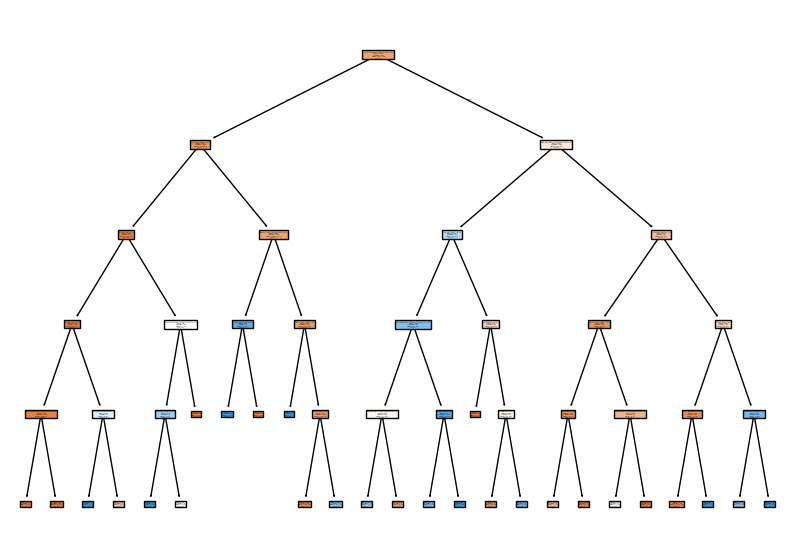

In [67]:
# Plotting First Tree
single_tree = best_rf.estimators_[0]
feature_cols = X_train.columns

fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(single_tree, 
                   feature_names=feature_cols,  
                   class_names=['0', '1'],
                   filled=True)

#### Hyperparameter fine tuning - creating a decision tree model

In [68]:
from sklearn.tree import DecisionTreeClassifier
from time import time

In [69]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [3, 5, 7, 10, 12, None],
                                  'min_samples_split': [5, 10, 15, 20, 40, 50, 60, 100],
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 10, 15, 20],
                                  'max_features':[None, 'sqrt', 'log2', 15, 20]},
                    cv = 10, # This is K - the number of folds
                    refit = True, # You want to re-train on each 9/10 folds
                    verbose = 2, # How much you want the gridsearch to explain what it does
                    n_jobs = -1, # This prompts sklearn to use all available CPU processors and speed up runtime if possible
                    scoring = 'accuracy') # Can be a bunch of other discrete metrics

In [70]:
# We're going to time it!

now = time() # log the current time on my machine

grid.fit(X_train, y_train) # Fit the gridsearch

print(f' Time in seconds: {time() - now}')

Fitting 10 folds for each of 2160 candidates, totalling 21600 fits


[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total t

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [71]:
# What was the best combination of parameters?
grid.best_params_

{'max_depth': 7,
 'max_features': 15,
 'min_samples_leaf': 20,
 'min_samples_split': 50}

In [72]:
grid.best_score_

0.866682098765432

In [73]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=7, max_features=15, min_samples_leaf=20,
                       min_samples_split=50)

In [74]:
best_dt_model = DecisionTreeClassifier(max_depth=12, max_features=20, min_samples_leaf=7, min_samples_split=60)

In [75]:
best_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, max_features=20, min_samples_leaf=7,
                       min_samples_split=60)

#### Visualise best_dt_model

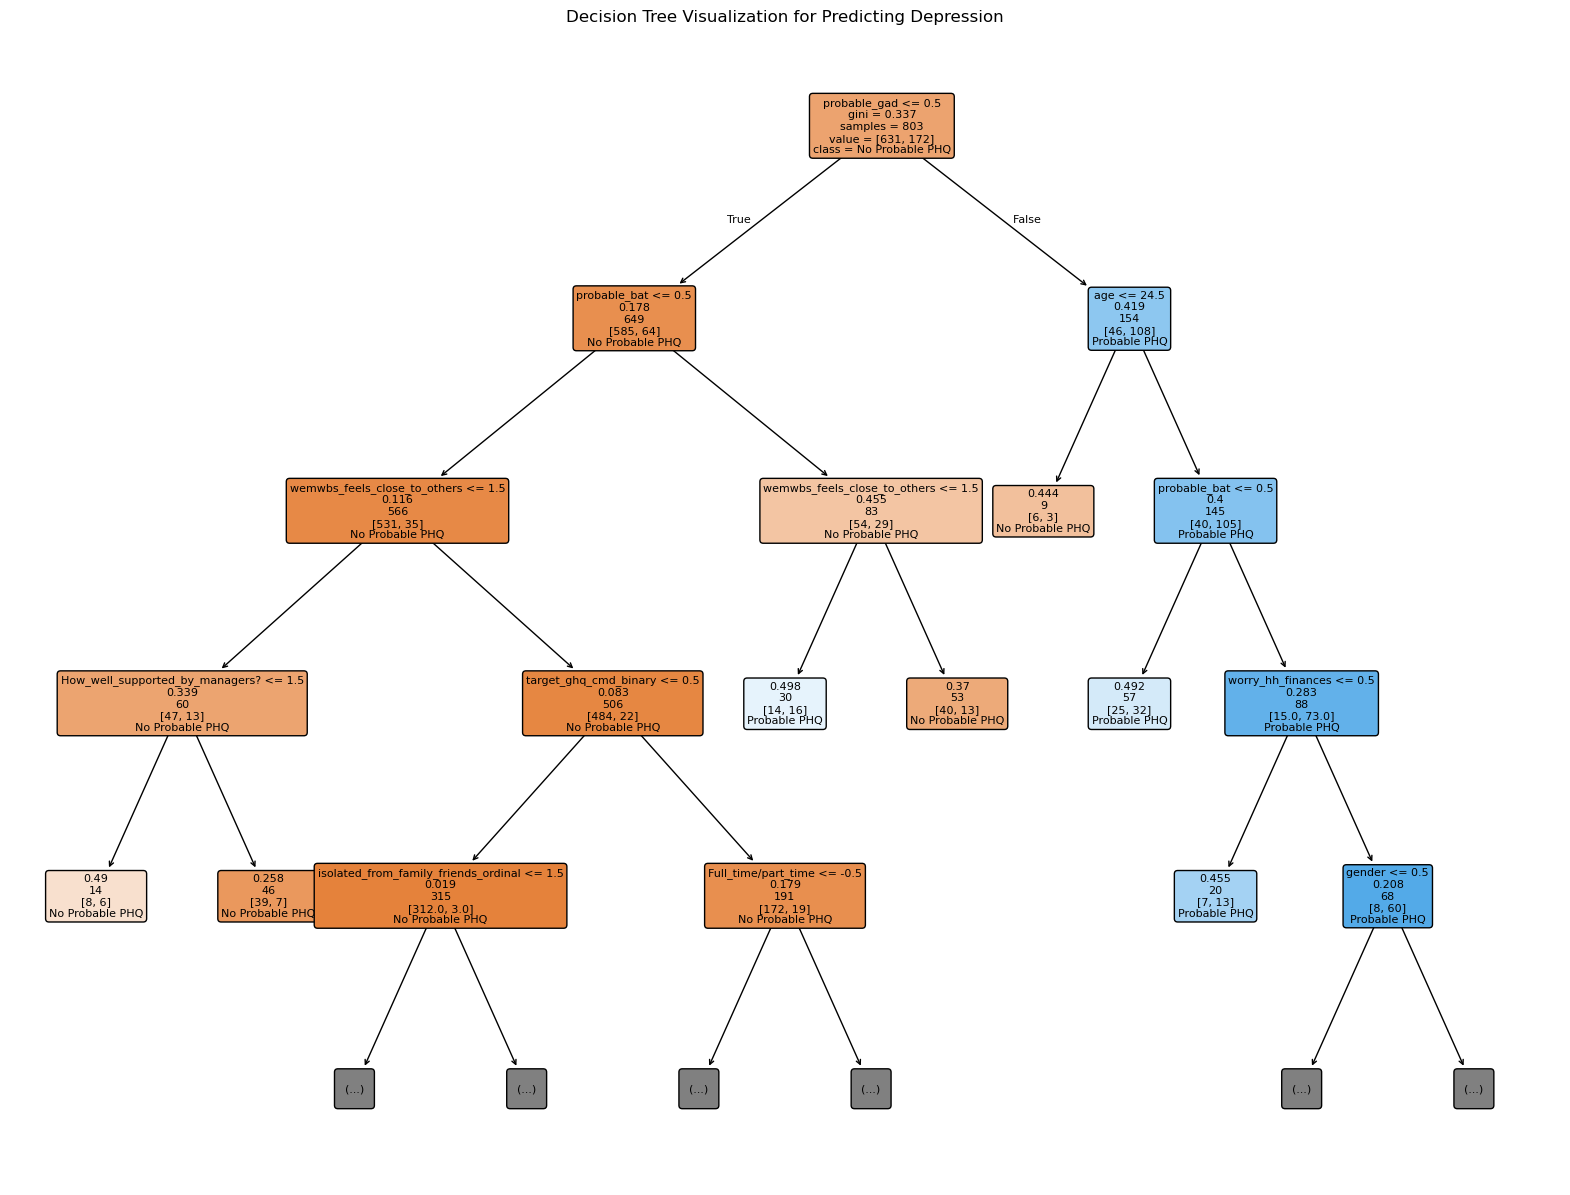

In [88]:

class_names_for_plot = ['No Probable PHQ', 'Probable PHQ']

# Get the max_depth from your best_dt_model's parameters
# This can help decide if plotting the full tree is feasible
tree_max_depth = best_dt_model.get_params().get('max_depth')

# --- Plotting the Decision Tree ---
plt.figure(figsize=(20,15)) # You might need to adjust figsize significantly


plot_depth = 4 # This changes the depth of the tree, depending on what I want to visualise

tree.plot_tree(best_dt_model,
               feature_names=feature_cols,
               class_names=class_names_for_plot,
               filled=True,
               rounded=True,
               proportion=False, 
               fontsize=8,       #
               max_depth=plot_depth, # Control how many levels of the tree to plot
               label='root')     # Show 'root' label for the top node

plt.title(f"Decision Tree Visualization for Predicting Depression")
plt.show()




#### compare Random Forests and Best Decision Tree Models on Test Set

In [76]:
y_pred_test_dt = best_dt_model.predict(X_test)
y_pred_proba_test_dt = best_dt_model.predict_proba(X_test)[:, 1] # For ROC AUC

Evaluate dt model

In [77]:
# Evaluate model.
print(f'Score on training set: {best_dt_model.score(X_train, y_train)}')
print(f'Score on testing set: {best_dt_model.score(X_test, y_test)}')

Score on training set: 0.8692403486924035
Score on testing set: 0.8955223880597015


In [78]:
#
train_results = X_train.copy() # Create a copy of X_test
train_results['y_pred'] = best_dt_model.predict(X_train) # Predict on X_test and attach
train_results['y_real'] = y_train # Attach the real values
train_results['y_prob'] = best_dt_model.predict_proba(X_train)[:,1] # Obtain probabilities

train_results.head()

age  gender  relationship_status  ethnic_group  role_type  pay_band_afc  \
84    24       0                    3            15          2            -1   
32    42       1                    2            14          0             7   
295   33       0                    2            15          1             7   
530   38       1                    3            15          0             8   
685   30       0                    2            15          0            -1   

     current_work_setting  contact_suspected_covid_work  \
84                      1                             0   
32                      1                             1   
295                     1                             0   
530                     1                             1   
685                     1                             1   

     How_well_supported_by_managers?  Full_time/part_time  worry_hh_finances  \
84                                 2                   -1                  1   
32                                 4                    1                  1   
295                                2                    0                  0   
530                                3                    1                  0   
685                                3                    0                  2   

     has_children_u18  knows_someone_died_covid_outside_work  \
84                  0                                      0   
32                  1                                      1   
295                 1                                      0   
530                 0                                      1   
685                 0                                      0   

     colleague_died_covid  wemwbs_feels_close_to_others  wemwbs_feels_loved  \
84                      0                             2                   3   
32                      1                             4                   4   
295                     0                             4                   4   
530                     0                             2                   2   
685                     0                             1                   3   

     careProvScoreCat  socDisconnectScoreCat  is_primary_care_worker  \
84                  0                      1                       1   
32                  0                      1                       1   
295                 0                      0                       1   
530                 0                      1                       1   
685                 0                      0                       1   

     used_support_service  target_ghq_cmd_binary  probable_gad  probable_bat  \
84                      0                      1             0             0   
32                      0                      1             0             0   
295                     1                      0             0             0   
530                     1                      0             0             1   
685                     0                      1             1             1   

     probable_pcl  isolated_from_family_friends_ordinal  y_pred  y_real  \
84              0                                     1       0       0   
32              0                                     2       0       0   
295             0                                     0       0       0   
530             0                                     1       0       0   
685             0                                     1       1       1   

       y_prob  
84   0.000000  
32   0.411765  
295  0.000000  
530  0.245283  
685  0.927273

In [79]:
test_results = X_test.copy()
test_results['y_pred'] = best_dt_model.predict(X_test)
test_results['y_real'] = y_test
test_results['y_prob'] = best_dt_model.predict_proba(X_test)[:,1]

test_results.head()

age  gender  relationship_status  ethnic_group  role_type  pay_band_afc  \
979   34       0                    2             0          2             5   
661   29       0                    0             2          1             5   
716   59       0                    0            15          2             5   
537   56       0                    2            15          1            -1   
385   26       0                    0            15          1             6   

     current_work_setting  contact_suspected_covid_work  \
979                     0                             1   
661                     0                             1   
716                     0                             1   
537                     0                             1   
385                     0                             0   

     How_well_supported_by_managers?  Full_time/part_time  worry_hh_finances  \
979                                3                   -1                  1   
661                                3                    1                  1   
716                                2                   -1                  1   
537                                3                   -1                  2   
385                                4                   -1                  1   

     has_children_u18  knows_someone_died_covid_outside_work  \
979                 0                                      0   
661                 0                                      0   
716                 0                                      0   
537                 1                                      1   
385                 0                                      0   

     colleague_died_covid  wemwbs_feels_close_to_others  wemwbs_feels_loved  \
979                     0                             2                   3   
661                     0                             1                   2   
716                     0                             2                   3   
537                     0                             2                   4   
385                     0                             3                   4   

     careProvScoreCat  socDisconnectScoreCat  is_primary_care_worker  \
979                 0                      1                       0   
661                 0                      2                       0   
716                 0                      1                       0   
537                 0                      1                       0   
385                 0                      0                       0   

     used_support_service  target_ghq_cmd_binary  probable_gad  probable_bat  \
979                     1                      0             0             0   
661                     0                      1             1             1   
716                     1                      1             0             0   
537                     1                      1             0             0   
385                     0                      0             0             1   

     probable_pcl  isolated_from_family_friends_ordinal  y_pred  y_real  \
979             0                                     1       0       0   
661             1                                     4       1       1   
716             0                                     1       0       0   
537             0                                     1       0       0   
385             0                                     0       0       1   

       y_prob  
979  0.000000  
661  0.927273  
716  0.000000  
537  0.000000  
385  0.245283

#### dt model evaluation

In [80]:
dt_results = apr(test_results['y_pred'], test_results['y_real'])

Accuracy:0.8955223880597015
Precision:0.7837837837837838
Recall:0.6904761904761905
F1:0.7341772151898734


Test accuracy =  0.8955223880597015


0.8955223880597015

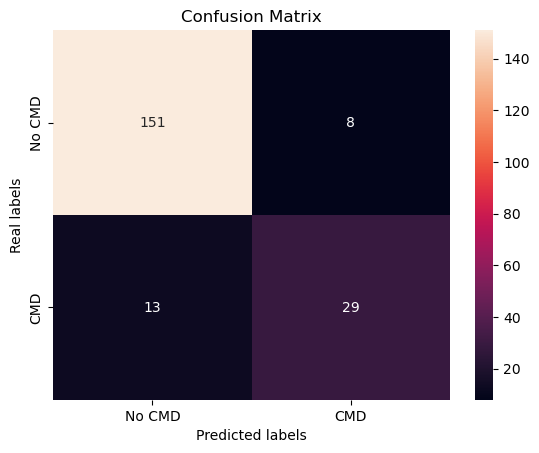

In [81]:
from sklearn.metrics import accuracy_score

produce_confusion('CMD', 'No CMD', 'binary', test_results, 'y_pred', 'y_real')

### 6.2 Decision

* The decision tree achieved a higher recall of 68.4% for Class 1 compared to the RF model at 64.0% for Class 1.

* Across other metrics, the two models achieve comparable overall performance.

* The decision tree will also be more interpretable for identifying feature importances and visualising them

**Therefore, I will use the fine-tuned Decision Tree model for identifying feature importances in my dataset.**

## 7. Visualisation

### 7.1 Feature Importance for DT model predicting probably depression

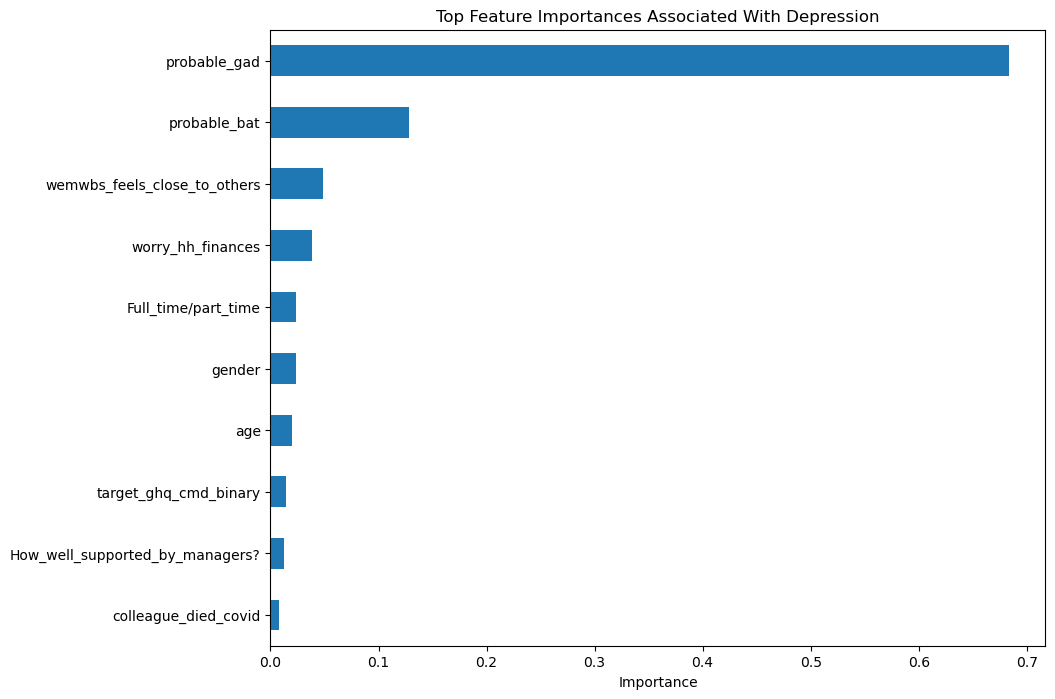

In [90]:

importances_dt = best_dt_model.feature_importances_
feature_names_dt = X_train.columns 

dt_importances = pd.Series(importances_dt, index=feature_names_dt).sort_values(ascending=False)


dt_importances.head(10) # Show top 15

plt.figure(figsize=(10, 8))
dt_importances.head(10).plot(kind='barh') # Plot top 15
plt.title("Top Feature Importances Associated With Depression")
plt.gca().invert_yaxis() # To display most important at the top
plt.xlabel("Importance")
plt.show()

### 7.2 feature importance for RF model predicting probably depression

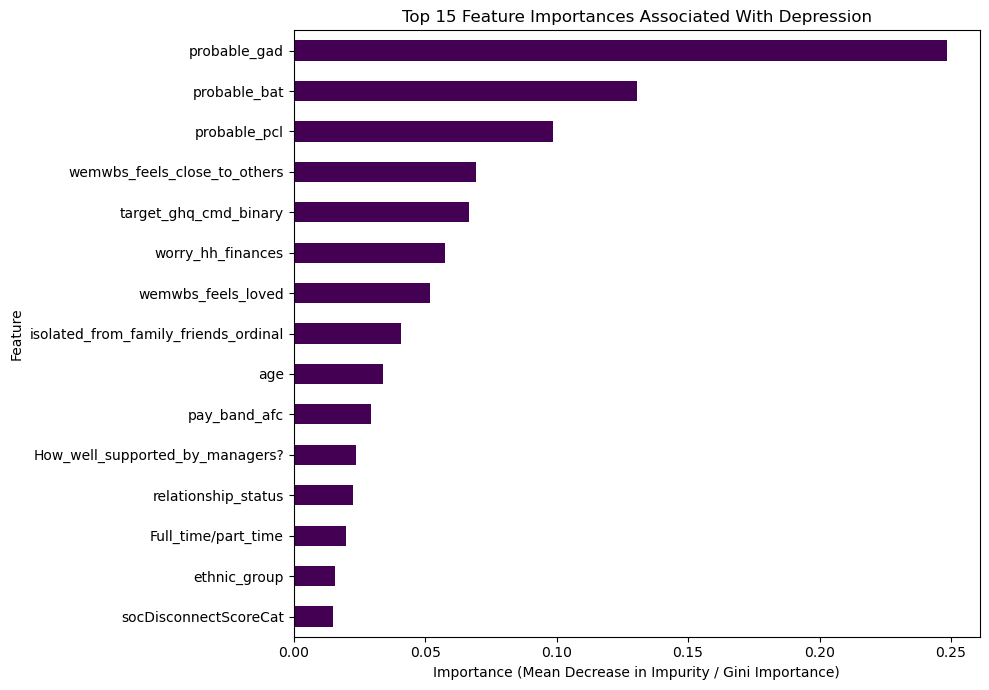

In [84]:
# Get feature importances from the Random Forest model
importances_rf = best_rf.feature_importances_

feature_names_rf = X_train.columns

# Create a Pandas Series for easy sorting and plotting
forest_importances = pd.Series(importances_rf, index=feature_names_rf)
forest_importances = forest_importances.sort_values(ascending=False)


# Plot the feature importances

plt.figure(figsize=(10, 7))


forest_importances.head(15).plot(kind='barh', colormap='viridis')
plt.title('Top 15 Feature Importances Associated With Depression')
plt.xlabel('Importance (Mean Decrease in Impurity / Gini Importance)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**For the final model, I am going to use the DT model that predicts probable_PHQ.**

## 8. Exporting to Tableau

I want to extract the feature importance information from my DT model so that I can import it into Tableau and visualise it there.

In [89]:

importances_dt = best_dt_model.feature_importances_

feature_names_dt = X_train.columns.tolist()


# Create a Pandas Series
dt_importances_series = pd.Series(importances_dt, index=feature_names_dt)
dt_importances_df = dt_importances_series.reset_index()
dt_importances_df.columns = ['Feature', 'Importance']

# Sort by importance
dt_importances_df = dt_importances_df.sort_values(by='Importance', ascending=False)


# Save as a .csv file
dt_importances_df.to_csv('mecare_feature_importances.csv', index=False)
